In [1]:
import os
import sys
# sys.path.append('/home/el2522/.local/lib/python3.8/site-packages')
sys.path.append('/data/master/DS217/users/el2522')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import torch
import torchtuples as tt
from torch.optim.lr_scheduler import StepLR


In [2]:
from pycox.models import DeepHitSingle
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.models.loss import rank_loss_deephit_single
import functools

from ehr_ts_representations.Models.torch.encoders.MLP import MLPEncoder as MLP
from ehr_ts_representations.Models.torch.encoders.RNN import RNNEncoder as RNN
from ehr_ts_representations.Models.torch.encoders.LSTM import LSTMEncoder as LSTM
from ehr_ts_representations.Models.torch.AE import AutoEncoder as AE

2024-09-16 23:05:17,881 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:51)


In [3]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.functions import StepFunction
from sksurv.metrics import (
    concordance_index_censored as c_index,
    cumulative_dynamic_auc,
    integrated_brier_score,
    as_integrated_brier_score_scorer
)
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator

from sklearn.utils import resample
from sklearn.model_selection import KFold

# from lifelines import KaplanMeierFitter


In [4]:
# Load the data
file_path = '/home/el2522/Documents/DS217/users/el2522/TrajectoryAnalysis/data/raw/df_ventilation_imputed_unfiltered.pkl'
all_df = pd.read_pickle(file_path)

In [5]:
file_path = '/home/el2522/Documents/DS217/users/el2522/TrajectoryAnalysis/data/preprocessed/tmp_tte/prepared_ttedata_12_dynamic_prediction.pkl'

df = pd.read_pickle(file_path)

### Data Prep for Time-to-event Prediction

In [6]:
def compute_tte(group_timestamp):
    max_timestamp = group_timestamp.max()
    return max_timestamp + 1 - group_timestamp

train_indices, val_indices, test_indices = df[0]['indices'], df[1]['indices'], df[2]['indices']


y_tracker_train = train_indices.merge(all_df[['encounterId', 'timestamp', 'event_description', 'num_intub', 'LOV',
                                             'first_extubation_time']], 
                                        on=['encounterId', 'timestamp'], how='left')
mask_train = (((y_tracker_train['first_extubation_time'].isna()) | 
               (y_tracker_train.timestamp < y_tracker_train['first_extubation_time'])) &
             (y_tracker_train.event_description.notna()))
y_tracker_train = y_tracker_train[mask_train].reset_index(drop=True)
y_tracker_train['time_to_event'] = y_tracker_train.groupby('encounterId')['timestamp'].transform(compute_tte)
y_tracker_train['event'] = ~(y_tracker_train.event_description.str.startswith('Not Extubated') | 
                             (y_tracker_train.num_intub>1))
y_tracker_train.loc[y_tracker_train.num_intub>1, 'event_description'] = 'Extubation Failure'


y_tracker_val = val_indices.merge(all_df[['encounterId', 'timestamp', 'event_description', 'num_intub', 'LOV',
                                         'first_extubation_time']], 
                                        on=['encounterId', 'timestamp'], how='left')
mask_val = (((y_tracker_val['first_extubation_time'].isna()) |
                                  (y_tracker_val.timestamp < y_tracker_val['first_extubation_time']))&
           (y_tracker_val.event_description.notna()))
y_tracker_val = y_tracker_val[mask_val].reset_index(drop=True)
y_tracker_val['time_to_event'] = y_tracker_val.groupby('encounterId')['timestamp'].transform(compute_tte)
y_tracker_val['event'] = ~(y_tracker_val.event_description.str.startswith('Not Extubated') | 
                             (y_tracker_val.num_intub>1))
y_tracker_val.loc[y_tracker_val.num_intub>1, 'event_description'] = 'Extubation Failure'

y_tracker_test = test_indices.merge(all_df[['encounterId', 'timestamp', 'event_description', 'num_intub', 'LOV',
                                           'first_extubation_time']], 
                                        on=['encounterId', 'timestamp'], how='left')
mask_test = (((y_tracker_test['first_extubation_time'].isna()) |
                                  (y_tracker_test.timestamp < y_tracker_test['first_extubation_time']))&
            (y_tracker_test.event_description.notna()))
y_tracker_test = y_tracker_test[mask_test].reset_index(drop=True)
y_tracker_test['time_to_event'] = y_tracker_test.groupby('encounterId')['timestamp'].transform(compute_tte)
y_tracker_test['event'] = ~(y_tracker_test.event_description.str.startswith('Not Extubated') | 
                             (y_tracker_test.num_intub>1))
y_tracker_test.loc[y_tracker_test.num_intub>1, 'event_description'] = 'Extubation Failure'



In [7]:
X_train_seq = df[0]['X'][mask_train].astype(np.float32)
y_train = (y_tracker_train['time_to_event'].values.astype('int'), y_tracker_train['event'].values.astype('float32'))

X_val_seq = df[1]['X'][mask_val].astype(np.float32)
y_val = (y_tracker_val['time_to_event'].values.astype('int'), y_tracker_val['event'].values.astype('float32'))

X_test_seq = df[2]['X'][mask_test].astype(np.float32)
y_test = (y_tracker_test['time_to_event'].values.astype('int'), y_tracker_test['event'].values.astype('float32'))

X_train_val_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_train_val = (np.concatenate([y_train[0], y_val[0]]), np.concatenate([y_train[1], y_val[1]]))

In [8]:
# Prepare tabular data
X_train_tab = X_train_seq[:, -1]
X_val_tab = X_val_seq[:, -1]
X_test_tab = X_test_seq[:, -1]
X_train_val_tab = X_train_val_seq[:, -1]


In [9]:
# # refine time steps to take consideration, taking a conservative approach
# step=12
# lower, upper = np.percentile(y_test[0], [0, 95])
# upper = 7*24 # tmp
# time_grid = np.arange(0, upper+step*2, step=step).astype(int)

In [9]:
# Label Transformation
labtrans = DeepHitSingle.label_transform(15, scheme='quantiles')  # Optional scheme='quantiles'
train_transformed = labtrans.fit(*y_train)
time_grid = np.array([x for x in labtrans.cuts[:-1]] + [420] + [labtrans.cuts[-1]])
time_grid

array([  0.,   6.,  13.,  20.,  28.,  38.,  48.,  60.,  73.,  90., 111.,
       143., 189., 275., 420., 648.])

In [11]:
# Label Transformation

labtrans = DeepHitSingle.label_transform(cuts=np.unique(time_grid).astype('float'))  # Optional scheme='quantiles'
train_transformed = labtrans.fit_transform(*y_train)
y_train = (np.array([labtrans.cuts[x] for x in train_transformed[0]]), 
                train_transformed[1])

val_transformed = labtrans.transform(*y_val)
y_val = (np.array([labtrans.cuts[x] for x in val_transformed[0]]),
              val_transformed[1])

train_val_transformed = labtrans.transform(*y_train_val)
y_train_val = (np.array([labtrans.cuts[x] for x in train_val_transformed[0]]),
                    train_val_transformed[1])

test_transformed = labtrans.transform(*y_test)
y_test = (np.array([labtrans.cuts[x] for x in test_transformed[0]]),
                    test_transformed[1])

durations_test, events_test = y_test



/data/master/DS217/users/el2522/TTEAnalysis/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


In [12]:
# Given your split, now let's create the structures for the survival analysis
def create_survival_data(durations, events):
    return Surv.from_arrays(event=events, time=durations)

# Prepare survival data for fitting the models
y_train_val_surv = create_survival_data(y_train_val[0], y_train_val[1])                                        


### Baselines

In [137]:
subsampling_fraction = .3
X_train_val_subsample, y_train_val_surv_subsample = resample(X_train_val_tab, y_train_val_surv,
                                                     n_samples=int(X_train_val_tab.shape[0] * subsampling_fraction),
                                                     stratify=y_train_val_surv['event'])

# Define cross-validator
cv = KFold(n_splits=5, shuffle=True)

# CoxPH Grid Search
param_grid_cox = {
    'estimator__alpha': [0.001, 0.01, 0.1, 1, 10]  # Regularization strengths
}

# Setup GridSearchCV with the Integrated Brier Score scorer
grid_search_cox = GridSearchCV(
    as_integrated_brier_score_scorer(CoxPHSurvivalAnalysis(), times=time_grid[:-2]),
    param_grid=param_grid_cox,
    cv=cv,
    n_jobs=8,
    error_score='raise'
).fit(X_train_val_tab, y_train_val_surv)

# RSF Model grid search setup with Integrated Brier Score
param_grid_rsf = {
    'estimator__n_estimators': [100, 200],
    'estimator__min_samples_leaf': [5, 15, 50, 100],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'estimator__max_depth': [None, 10, 20, 30]  
}

# Setup GridSearchCV with the Integrated Brier Score scorer
grid_search_rsf = GridSearchCV(
    as_integrated_brier_score_scorer(RandomSurvivalForest(random_state=42), times=time_grid),
    param_grid=param_grid_rsf,
    cv=cv,
    n_jobs=8,
    error_score='raise'
).fit(X_train_val_subsample, y_train_val_surv_subsample)

# Results
print("Best parameters for CoxPH:", grid_search_cox.best_params_)
print("Best score for CoxPH:", grid_search_cox.best_score_)
print("Best parameters for RSF:", grid_search_rsf.best_params_)
print("Best score for RSF:", grid_search_rsf.best_score_)


KeyboardInterrupt: 

In [380]:
try:
    # Extract best parameters and remove the 'estimator__' prefix
    best_params_cox = {k.replace('estimator__', ''): v for k, v in grid_search_cox.best_params_.items()}
    best_params_rsf = {k.replace('estimator__', ''): v for k, v in grid_search_rsf.best_params_.items()}
except (AttributeError, NameError) as e:
    # Handling the case where grid_search was not performed
    print(f"Error occurred: {e}")
    # Assign default values if extraction fails
    best_params_cox = {'alpha': 10}
    best_params_rsf = {'max_depth': 30, 'max_features': None,
                       'min_samples_leaf': 5, 'n_estimators': 300}

# Initialize the CoxPH model with a penalizer term to help with potential multicollinearity
cph_model = CoxPHSurvivalAnalysis(**best_params_cox)
cph_model.fit(X_train_val_tab, y_train_val_surv)

# For rsf - Define the fraction of the data you want to keep. For example, 0.1 for 10%
subsampling_fraction = .3

# Perform subsampling
X_train_val_subsample, y_train_val_surv_subsample = resample(X_train_val_tab, y_train_val_surv, 
                                                     n_samples=int(X_train_val_tab.shape[0] * subsampling_fraction), 
                                                     stratify=y_train_val_surv['event'])

rsf_model = RandomSurvivalForest(**best_params_rsf, n_jobs=8)
rsf_model.fit(X_train_val_subsample, y_train_val_surv_subsample)



Error occurred: name 'grid_search_cox' is not defined


RandomSurvivalForest(max_depth=30, max_features=None, min_samples_leaf=5,
                     n_estimators=300, n_jobs=8)

### Deep learning baselines

In [381]:
labtrans = DeepHitSingle.label_transform(cuts=np.unique(y_train[0]).astype(float))  # scheme='quantiles'
y_train_disc = labtrans.fit_transform(*y_train)
y_val_disc = labtrans.transform(*y_val)

labtrans = DeepHitSingle.label_transform(cuts=np.unique(y_train[0]).astype(float))  # scheme='quantiles'
y_train_val_disc = labtrans.fit_transform(*y_train_val)


/data/master/DS217/users/el2522/TTEAnalysis/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


In [382]:

from sklearn.model_selection import KFold


class LRSchedulerCallback(tt.callbacks.Callback):
    """Callback for handling PyTorch learning rate schedulers."""
    def __init__(self, scheduler, update_on_batch=False):
        """
        Args:
            scheduler: Instance of torch.optim.lr_scheduler.
            update_on_batch: Bool, if True update on batch end, otherwise on epoch end.
        """
        self.scheduler = scheduler
        self.update_on_batch = update_on_batch

    def on_epoch_end(self):
        if not self.update_on_batch:
            self.scheduler.step()

    def on_batch_end(self):
        if self.update_on_batch:
            self.scheduler.step()


def initialize_encoder(config, encoder_fn):
    """ Initialize the model based on configuration """
    net = encoder_fn(**config['encoder_config'])
    optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    return net, optimizer


def train_model(encoder_fn, model_fn, config, X_train, y_train, X_val=None, y_val=None, 
                hazard_based=False, verbose=True):
    net, optimizer = initialize_encoder(config, encoder_fn)
    scheduler_config = config.get('scheduler_config')
    if scheduler_config is not None:
        scheduler = StepLR(optimizer, **config['scheduler_config'])
    model_params = {key: config[key] for key in ['alpha', 'sigma', 'duration_index'] if key in config}
    model = model_fn(net, optimizer, **model_params)

    if (X_val is not None) and (y_val is not None):
        val_data=(X_val, y_val)
        es_dataset = 'val'
    else:
        val_data = None
        es_dataset = 'train'
        
    callbacks = [
        tt.callbacks.EarlyStopping(patience=5, min_delta=0.0001, dataset=es_dataset),
        tt.callbacks.ClipGradNorm(net, max_norm=1.0),
        LRSchedulerCallback(scheduler)
    ]
    
    log = model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'],
                    callbacks=callbacks, num_workers=8, val_data=val_data, verbose=verbose,
                   metrics={'RankLoss': fixed_sigma_rank_loss})
    
    if val_data is not None:
        _ = model.compute_baseline_hazards() if hazard_based else None
        predictions = model.predict_surv_df(X_val)
        return model, predictions
    
    return model, None

def perform_cross_validation(X, y, encoder_fn, model_fn, config, kfolds=5, hazard_based=False):
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
    integrated_bs_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = (y[0][train_index], y[1][train_index]), (y[0][val_index], y[1][val_index])

        # Assuming a function to train and return the model and predictions
        model, predictions = train_model(encoder_fn, model_fn, config, X_train, y_train, X_val, y_val, 
                                         hazard_based, verbose=False)
        eval_surv = EvalSurv(predictions, y_val[0], y_val[1], censor_surv='km')
        integrated_bs = eval_surv.integrated_brier_score(np.linspace(y_val[0].min(), y_val[1].max(), 24))
        integrated_bs_scores.append(integrated_bs)

    # Average the Integrated Brier Score across all folds
    avg_integrated_bs = np.mean(integrated_bs_scores)
    return avg_integrated_bs

def grid_search_cv(X, y, encoder_fn, model_fn, param_grid, kfolds=5, hazard_based=False):
    best_score = float('inf')
    best_config = None
    best_model = None

    for config in param_grid:
        print(f"Evaluating configuration: {config}")  # For tracking progress
        try:
            avg_integrated_bs = perform_cross_validation(X, y, encoder_fn, model_fn, config, kfolds, hazard_based)
            print(f"Average Integrated Brier Score for current config: {avg_integrated_bs}")

            if avg_integrated_bs < best_score:
                best_score = avg_integrated_bs
                best_config = config
        except Exception as e:
            print(f"Error with configuration {config}: {e}")  # Error handling

    if best_config:
        print(f"Best configuration found: {best_config} with score {best_score}, retraining on the full dataset...")
        best_model, _ = train_model(encoder_fn, model_fn, best_config, X, y, None, None, 
                                    hazard_based=hazard_based, verbose=True)
        print("Retraining completed.")

    return best_model, best_config


In [426]:
import itertools

def generate_combinations(param_dict):
    # Helper function to ensure all elements are lists for consistent processing
    def ensure_iterable(val):
        if isinstance(val, list):
            return val
        else:
            return [val]

    # Recursive function to expand the grid
    def expand_grid(dictionary):
        if isinstance(dictionary, dict):
            keys = dictionary.keys()
            vals = dictionary.values()
            # Ensure all values are iterable, and recurse if they are dictionaries
            product_args = [expand_grid(v) if isinstance(v, dict) else ensure_iterable(v) for v in vals]
            for instance in itertools.product(*product_args):
                # Use zip to pair each set of parameters with their corresponding keys
                yield dict(zip(keys, instance))
        else:
            yield dictionary

    # Start the recursive expansion
    return list(expand_grid(param_dict))

param_grid = {
    'encoder_config': {
        'input_dim': [X_train_tab.shape[-1]],
        'dims': [[64, 64], [128, 128], [64, 128, 64]],
        'output_dim': labtrans.out_features,
        'batch_norm': [True],
        'dropout': [0.5],
        'output_bias': [True]
    },
    'lr': [1e-3, 1e-4, 1e-5],  # Learning rate options
    'weight_decay': [1e-5],  # Weight decay options
    'alpha': [0.5],  # Model-specific parameter
    'sigma': [0.3],  # Model-specific parameter
    'duration_index': [labtrans.cuts],  # For models needing discretized time cuts
    'epochs': [100],  # Number of epochs to test
    'batch_size': [512]  # Batch size options
}

expanded_param_grid = generate_combinations(param_grid)

deephit_mlp_model, deephit_mlp_config = grid_search_cv(X_train_val_tab, y_train_val_disc, 
                                                       MLP, DeepHitSingle, expanded_param_grid, kfolds=3)

Evaluating configuration: {'encoder_config': {'input_dim': 48, 'dims': [64, 64], 'output_dim': 44, 'batch_norm': True, 'dropout': 0.5, 'output_bias': True}, 'lr': 0.001, 'weight_decay': 1e-05, 'alpha': 0.5, 'sigma': 0.3, 'duration_index': array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.]), 'epochs': 100, 'batch_size': 512}
Error with configuration {'encoder_config': {'input_dim': 48, 'dims': [64, 64], 'output_dim': 44, 'batch_norm': True, 'dropout': 0.5, 'output_bias': True}, 'lr': 0.001, 'weight_decay': 1e-05, 'alpha': 0.5, 'sigma': 0.3, 'duration_index': array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 

In [383]:
import functools

# Set sigma to a fixed value, e.g., 0.3
fixed_sigma_rank_loss = functools.partial(rank_loss_deephit_single, sigma=0.8)

In [384]:

deephit_mlp_config = {
    'encoder_config': {
        'input_dim': X_train_tab.shape[-1],
        'dims': [64, 64],
        'output_dim': labtrans.out_features,
        'batch_norm': True,
        'dropout': 0.6,
        'output_bias': True
    },
    'scheduler_config': {
        'step_size': 10,
        'gamma': 0.5
    },
    'lr': 1e-4,  # Learning rate options
    'weight_decay': 1e-5,  # Weight decay options
    'alpha': 0.6,  # Model-specific parameter
    'sigma': 0.8,  # Model-specific parameter
    'duration_index': labtrans.cuts,  # For models needing discretized time cuts
    'epochs': 100,  # Number of epochs to test
    'batch_size': 256  # Batch size options
}

deephit_mlp_model, _ = train_model(MLP, DeepHitSingle, deephit_mlp_config, X_train_tab, y_train_disc,
                                   X_val_tab, y_val_disc, hazard_based=False, verbose=True)



0:	[32s / 32s],		train_loss: 1.7837,	train_RankLoss: 0.4042,	val_loss: 1.6227,	val_RankLoss: 0.3876
1:	[33s / 1m:5s],		train_loss: 1.6744,	train_RankLoss: 0.3908,	val_loss: 1.5792,	val_RankLoss: 0.3777
2:	[34s / 1m:40s],		train_loss: 1.6167,	train_RankLoss: 0.3818,	val_loss: 1.5464,	val_RankLoss: 0.3687
3:	[34s / 2m:14s],		train_loss: 1.5783,	train_RankLoss: 0.3752,	val_loss: 1.5198,	val_RankLoss: 0.3627
4:	[33s / 2m:47s],		train_loss: 1.5537,	train_RankLoss: 0.3714,	val_loss: 1.5042,	val_RankLoss: 0.3603
5:	[33s / 3m:21s],		train_loss: 1.5361,	train_RankLoss: 0.3686,	val_loss: 1.4940,	val_RankLoss: 0.3581
6:	[33s / 3m:54s],		train_loss: 1.5251,	train_RankLoss: 0.3671,	val_loss: 1.4842,	val_RankLoss: 0.3566
7:	[33s / 4m:27s],		train_loss: 1.5153,	train_RankLoss: 0.3653,	val_loss: 1.4800,	val_RankLoss: 0.3564
8:	[32s / 5m:0s],		train_loss: 1.5099,	train_RankLoss: 0.3646,	val_loss: 1.4757,	val_RankLoss: 0.3552
9:	[33s / 5m:33s],		train_loss: 1.5055,	train_RankLoss: 0.3637,	val_loss: 1.47

In [ ]:
# grid search for deepsurv

param_grid = {
    'encoder_config': {
        'input_dim': X_train_tab.shape[-1],
        'dims': [[64, 64], [128, 128], [64, 128, 64]],
        'output_dim': 1,
        'batch_norm': True,
        'dropout': 0.5,
        'output_bias': True
    },
    'lr': 1e-4,  # Learning rate options
    'weight_decay': 1e-5,  # Weight decay options
    'epochs': 100,  # Number of epochs to test
    'batch_size': 512  # Batch size options
}

expanded_param_grid = generate_combinations(param_grid)

deepsurv_mlp_model, deepsurv_mlp_config = grid_search_cv(X_train_val_tab, y_train_val, MLP, CoxPH, 
                                                       expanded_param_grid, kfolds=3, hazard_based=True)

In [115]:

deepsurv_mlp_config = {
    'encoder_config': {
        'input_dim': X_train_tab.shape[-1],
        'dims': [64, 128, 64],
        'output_dim': 1,
        'batch_norm': True,
        'dropout': 0.5,
        'output_bias': True
    },
    'scheduler_config': {
        'step_size': 10,
        'gamma': 0.5
    },
    'lr': 1e-4,  # Learning rate options
    'weight_decay': 1e-5,  # Weight decay options
    'epochs': 100,  # Number of epochs to test
    'batch_size': 256  # Batch size options
}

deepsurv_mlp_model, _ = train_model(MLP, CoxPH, deepsurv_mlp_config, X_train_tab, y_train,
                                   X_val_tab, y_val, hazard_based=True, verbose=True)


TypeError: rank_loss_deephit_single() missing 1 required positional argument: 'rank_mat'

### Dynamic Prediction

In [429]:

param_grid = {
    'encoder_config': {
        'input_dim': [X_train_seq.shape[-1]],
        'dims': [[64], [128], [256]],
        'output_dim': labtrans.out_features,
        'rnn_n_layers':[2],
        'dropout': [0.5, 0.8],
        'rnn_kwargs': {}
    },
    'scheduler_config': {
        'step_size': [10],
        'gamma': [0.5]
    },
    'lr': [1e-4, 1e-5],  # Learning rate options
    'weight_decay': [1e-5],  # Weight decay options
    'alpha': [0.8],  # Model-specific parameter
    'sigma': [0.5, 0.8],  # Model-specific parameter
    'duration_index': [labtrans.cuts],  # For models needing discretized time cuts
    'epochs': [100],  # Number of epochs to test
    'batch_size': [256]  # Batch size options
}

expanded_param_grid = generate_combinations(param_grid)

deephit_rnn_model, deephit_rnn_config = grid_search_cv(X_train_val_seq, y_train_val_disc, 
                                                       LSTM, DeepHitSingle, expanded_param_grid, kfolds=2)

Evaluating configuration: {'encoder_config': {'input_dim': 48, 'dims': [64], 'output_dim': 44, 'rnn_n_layers': 2, 'dropout': 0.5, 'rnn_kwargs': {}}, 'scheduler_config': {'step_size': 10, 'gamma': 0.5}, 'lr': 0.0001, 'weight_decay': 1e-05, 'alpha': 0.8, 'sigma': 0.5, 'duration_index': array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.]), 'epochs': 100, 'batch_size': 256}
Average Integrated Brier Score for current config: 0.0007664126371698276
Evaluating configuration: {'encoder_config': {'input_dim': 48, 'dims': [64], 'output_dim': 44, 'rnn_n_layers': 2, 'dropout': 0.5, 'rnn_kwargs': {}}, 'scheduler_config': {'step_size': 10, 'gamma': 0.5}, 'lr': 0.0001, 'weight_decay': 1e-05, 'alpha': 0.8, 'sigma': 0.8, 'duration_index': array([  0.,   4.,   8.,  12.

Average Integrated Brier Score for current config: 0.0007666286168228663
Evaluating configuration: {'encoder_config': {'input_dim': 48, 'dims': [128], 'output_dim': 44, 'rnn_n_layers': 2, 'dropout': 0.8, 'rnn_kwargs': {}}, 'scheduler_config': {'step_size': 10, 'gamma': 0.5}, 'lr': 0.0001, 'weight_decay': 1e-05, 'alpha': 0.8, 'sigma': 0.8, 'duration_index': array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.]), 'epochs': 100, 'batch_size': 256}
Average Integrated Brier Score for current config: 0.0007666390021809997
Evaluating configuration: {'encoder_config': {'input_dim': 48, 'dims': [128], 'output_dim': 44, 'rnn_n_layers': 2, 'dropout': 0.8, 'rnn_kwargs': {}}, 'scheduler_config': {'step_size': 10, 'gamma': 0.5}, 'lr': 1e-05, 'weight_decay': 1e-05, '

0:	[12s / 12s],		train_loss: 2.7882,	train_RankLoss: 0.4016
1:	[12s / 25s],		train_loss: 2.7211,	train_RankLoss: 0.4033
2:	[13s / 38s],		train_loss: 2.6269,	train_RankLoss: 0.4028
3:	[13s / 51s],		train_loss: 2.5582,	train_RankLoss: 0.4010
4:	[12s / 1m:4s],		train_loss: 2.5149,	train_RankLoss: 0.3982
5:	[13s / 1m:17s],		train_loss: 2.4820,	train_RankLoss: 0.3942
6:	[12s / 1m:30s],		train_loss: 2.4577,	train_RankLoss: 0.3905
7:	[12s / 1m:43s],		train_loss: 2.4365,	train_RankLoss: 0.3864
8:	[12s / 1m:56s],		train_loss: 2.4210,	train_RankLoss: 0.3836
9:	[12s / 2m:9s],		train_loss: 2.4085,	train_RankLoss: 0.3811
10:	[13s / 2m:22s],		train_loss: 2.3994,	train_RankLoss: 0.3792
11:	[13s / 2m:35s],		train_loss: 2.3938,	train_RankLoss: 0.3783
12:	[12s / 2m:48s],		train_loss: 2.3902,	train_RankLoss: 0.3778
13:	[12s / 3m:1s],		train_loss: 2.3846,	train_RankLoss: 0.3770
14:	[12s / 3m:14s],		train_loss: 2.3808,	train_RankLoss: 0.3762
15:	[13s / 3m:28s],		train_loss: 2.3774,	train_RankLoss: 0.3753
1

In [394]:
from pathlib import Path
current_dir = Path('/home/el2522/Documents/DS217/users/el2522/TTEAnalysis')
common_parent = current_dir.parent
traj_analysis_dir = common_parent / "TrajectoryAnalysis"
sys.path.append(str(traj_analysis_dir))

# Now you can import from the TrajectoryAnalysis project
from src.encoders.lstm import LSTMEncoder, EncoderConfig

deephit_rnn_config = {
    'encoder_config': {
        'config': EncoderConfig(**{
            'input_dim': X_train_seq.shape[-1],
            'hidden_dims': [64, 64],
            'output_dim': labtrans.out_features,
            'dropout': 0.7,
            'rnn_n_layers':1,
            'rnn_kwargs': {}}
        )
    },
    'scheduler_config': {
        'step_size': 5,
        'gamma': 0.5
    },
    'lr': 4e-5,  # Learning rate options
    'weight_decay': 1e-5,  # Weight decay options
    'alpha': 0.6,  # Model-specific parameter
    'sigma': 0.8,  # Model-specific parameter
    'duration_index': labtrans.cuts,  # For models needing discretized time cuts
    'epochs': 100,  # Number of epochs to test
    'batch_size': 256  # Batch size options
}


deephit_rnn_model, _ = train_model(LSTMEncoder, DeepHitSingle, deephit_rnn_config, X_train_seq, y_train_disc,
                                   X_val_seq, y_val_disc, hazard_based=False, verbose=True)

0:	[32s / 32s],		train_loss: 1.6866,	train_RankLoss: 0.4037,	val_loss: 1.6285,	val_RankLoss: 0.3959
1:	[32s / 1m:4s],		train_loss: 1.6155,	train_RankLoss: 0.3883,	val_loss: 1.5420,	val_RankLoss: 0.3717
2:	[32s / 1m:37s],		train_loss: 1.5608,	train_RankLoss: 0.3734,	val_loss: 1.5118,	val_RankLoss: 0.3635
3:	[32s / 2m:9s],		train_loss: 1.5330,	train_RankLoss: 0.3669,	val_loss: 1.4940,	val_RankLoss: 0.3592
4:	[31s / 2m:41s],		train_loss: 1.5152,	train_RankLoss: 0.3625,	val_loss: 1.4838,	val_RankLoss: 0.3560
5:	[32s / 3m:14s],		train_loss: 1.5053,	train_RankLoss: 0.3600,	val_loss: 1.4796,	val_RankLoss: 0.3551
6:	[33s / 3m:47s],		train_loss: 1.4992,	train_RankLoss: 0.3585,	val_loss: 1.4766,	val_RankLoss: 0.3544
7:	[32s / 4m:19s],		train_loss: 1.4934,	train_RankLoss: 0.3574,	val_loss: 1.4744,	val_RankLoss: 0.3532
8:	[31s / 4m:51s],		train_loss: 1.4880,	train_RankLoss: 0.3561,	val_loss: 1.4713,	val_RankLoss: 0.3524
9:	[32s / 5m:23s],		train_loss: 1.4827,	train_RankLoss: 0.3547,	val_loss: 1.46

### With AE

In [572]:

def load_checkpoint(model, optimizer, filename="mdl_chkpnt_epoch_1.pt"):
    """
    Load a model checkpoint.
    
    Args:
        model (torch.nn.Module): The model that you want to load the checkpoint into.
        optimizer (torch.optim.Optimizer): The optimizer used for training the model.
        filename (str): Path to the checkpoint file.
        
    Returns:
        int: The epoch number at which this checkpoint was saved.
    """
    # Make sure to load the checkpoint according to the device
    checkpoint = torch.load(filename, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']  # If you want to use it
    
    print(f"Checkpoint loaded: {filename} at epoch {epoch}")
    print(f"Loss at checkpoint: {loss}")
    
    return epoch

# Define the dimensions for the MLP encoder and decoder
input_dim = X_train_tab.shape[-1]
dims = [64, 64]
output_dim = int(X_train_tab.shape[-1]/2)
batch_norm = True
dropout = 0.3

# Create instances of the MLP class for the encoder and decoder
ae_encoder = MLP(input_dim, dims, output_dim, batch_norm, dropout)
ae_decoder = MLP(output_dim, dims[::-1], input_dim, batch_norm, dropout)

# Define the number of clusters for the AutoEncoder
n_clusters = 10

# Create an instance of the AutoEncoder class
ae_model = AE(encoder=ae_encoder, decoder=ae_decoder, n_clusters=n_clusters)
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-4, weight_decay=1e-5)
filename = './model_checkpoints/mdl_chkpnt_epoch_37.pt'  # Adjust the path and filename as needed

last_epoch = load_checkpoint(ae_model, ae_optimizer, filename)

# Continue training or evaluation from here


Checkpoint loaded: ./model_checkpoints/mdl_chkpnt_epoch_37.pt at epoch 37
Loss at checkpoint: 0.3733501194723394


In [573]:

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def extract_features(dataset, model, include_clust_assign=False, scaler=None):
    """Extract features from a dataset using a pretrained model, 
    optionally including cluster assignments, and standardize features.

    Args:
        dataset (Union[np.ndarray, torch.Tensor]): Dataset to process.
        model (torch.nn.Module): Pretrained model used for feature extraction.
        include_clust_assign (bool): Whether to concatenate one-hot encoded cluster assignments with the latent vectors.
        scaler (StandardScaler, optional): A pre-fitted scaler for standardizing features; if None, a new scaler will be fitted.

    Returns:
        np.ndarray: Processed features, possibly concatenated with one-hot encoded cluster assignments and standardized.
    """
    # Ensure dataset is a torch.Tensor
    if not isinstance(dataset, torch.Tensor):
        dataset = torch.tensor(dataset, dtype=torch.float32)
    
    # Align dataset device with model device
    model_device = next(model.parameters()).device
    dataset = dataset.to(model_device)
    
    # Forward pass through the model in no_grad context
    with torch.no_grad():
        output = model(dataset)
        features = output.encoded.cpu().detach().numpy()

        if include_clust_assign:
            clust_assign = output.clust_assign.cpu().detach().numpy()
            encoder = OneHotEncoder(sparse_output=False)
            clust_assign_encoded = encoder.fit_transform(clust_assign.reshape(-1, 1))
            features = np.hstack((features, clust_assign_encoded))
    
    # Standardize features
    if scaler is None:
        scaler = MinMaxScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
    
    return features.astype(np.float32), scaler

ae_model.eval()
for param in ae_model.parameters():
    param.requires_grad = False

# For training, fit a new scaler
Z_train, ae_scaler = extract_features(X_train_tab, ae_model, include_clust_assign=False)
Z_val, _ = extract_features(X_val_tab, ae_model, include_clust_assign=False, scaler=ae_scaler)
Z_test, _ = extract_features(X_test_tab, ae_model, include_clust_assign=False, scaler=ae_scaler)


In [574]:

deephit_mlp_ae_config = {
    'encoder_config': {
        'input_dim': Z_train.shape[-1],
        'dims': [64, 64],
        'output_dim': labtrans.out_features,
        'batch_norm': True,
        'dropout': 0.5,
        'output_bias': True
    },
    'scheduler_config': {
        'step_size': 10,
        'gamma': 0.5
    },
    'lr': 4e-4,  # Learning rate options
    'weight_decay': 1e-5,  # Weight decay options
    'alpha': 0.8,  # Model-specific parameter
    'sigma': 0.8,  # Model-specific parameter
    'duration_index': labtrans.cuts,  # For models needing discretized time cuts
    'epochs': 100,  # Number of epochs to test
    'batch_size': 256  # Batch size options
}

deephit_mlp_ae_model, _ = train_model(MLP, DeepHitSingle, deephit_mlp_ae_config, Z_train, y_train_disc,
                                   Z_val, y_val_disc, hazard_based=False, verbose=True)


0:	[20s / 20s],		train_loss: 2.0566,	train_RankLoss: 0.3785,	val_loss: 1.8603,	val_RankLoss: 0.3582
1:	[19s / 39s],		train_loss: 1.9170,	train_RankLoss: 0.3644,	val_loss: 1.7976,	val_RankLoss: 0.3494
2:	[19s / 59s],		train_loss: 1.8704,	train_RankLoss: 0.3583,	val_loss: 1.7771,	val_RankLoss: 0.3450
3:	[20s / 1m:20s],		train_loss: 1.8489,	train_RankLoss: 0.3544,	val_loss: 1.7681,	val_RankLoss: 0.3443
4:	[20s / 1m:40s],		train_loss: 1.8397,	train_RankLoss: 0.3530,	val_loss: 1.7666,	val_RankLoss: 0.3432
5:	[20s / 2m:0s],		train_loss: 1.8326,	train_RankLoss: 0.3513,	val_loss: 1.7628,	val_RankLoss: 0.3431
6:	[20s / 2m:20s],		train_loss: 1.8279,	train_RankLoss: 0.3507,	val_loss: 1.7604,	val_RankLoss: 0.3428
7:	[20s / 2m:40s],		train_loss: 1.8240,	train_RankLoss: 0.3500,	val_loss: 1.7593,	val_RankLoss: 0.3420
8:	[20s / 3m:0s],		train_loss: 1.8218,	train_RankLoss: 0.3497,	val_loss: 1.7572,	val_RankLoss: 0.3414
9:	[19s / 3m:20s],		train_loss: 1.8195,	train_RankLoss: 0.3493,	val_loss: 1.7567,	va

## Evaluation

In [386]:
# Prepare for evaluation
max_train_value = y_train_val[0].max()
mask = np.where(durations_test>=max_train_value)
index_before_max = np.where(time_grid == max_train_value)[0][0] - 1
durations_test[mask] = time_grid[index_before_max]
y_test = (durations_test, events_test)
# y_tracker_test = y_tracker_test.iloc[mask[0], :]

y_test_surv = create_survival_data(durations_test, events_test)

In [387]:
time_grid_eval = np.array([x for x in time_grid[:-2] if x!=0])

In [395]:
# random_surv = 0.5 * np.ones((time_grid.shape[0], y_test_surv.shape[0]))
km_func = StepFunction(*kaplan_meier_estimator(events_test.astype(bool), durations_test))
km_surv_np = np.tile(km_func(time_grid_eval), (y_test_surv.shape[0], 1))
km_surv = pd.DataFrame(km_surv_np.transpose(), index=time_grid_eval)

cph_surv_np = np.row_stack([fn(time_grid_eval) for fn in cph_model.predict_survival_function(X_test_tab)])
cph_surv = pd.DataFrame(cph_surv_np.transpose(), index=time_grid_eval)
rsf_surv_np = np.row_stack([fn(time_grid_eval) for fn in rsf_model.predict_survival_function(X_test_tab)])
rsf_surv = pd.DataFrame(rsf_surv_np.transpose(), index=time_grid_eval)

deephit_mlp_surv = deephit_mlp_model.predict_surv_df(X_test_tab)

# _ = deepsurv_mlp_model.compute_baseline_hazards()
# deepsurv_mlp_surv = deepsurv_mlp_model.predict_surv_df(X_test_tab)

deephit_rnn_surv = deephit_rnn_model.predict_surv_df(X_test_seq)

# deephit_mlp_ae_surv = deephit_mlp_ae_model.predict_surv_df(Z_test)


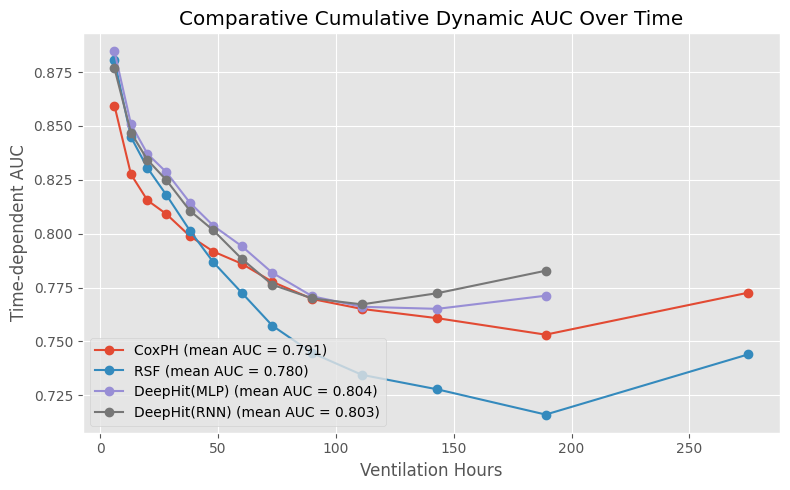

In [396]:
km_risk_scores = 1-km_surv_np
km_auc, km_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, km_risk_scores, time_grid_eval)

cph_risk_scores = cph_model.predict(X_test_tab)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, cph_risk_scores, time_grid_eval)

rsf_chf_funcs = rsf_model.predict_cumulative_hazard_function(X_test_tab, return_array=False)
rsf_risk_scores = np.row_stack([chf(time_grid_eval) for chf in rsf_chf_funcs])
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, rsf_risk_scores, time_grid_eval)

mask_deephit = [(x >= time_grid_eval.min()) & (x < time_grid_eval.max()) for x in deephit_mlp_surv.index]
deephit_mlp_risk_scores = (1-deephit_mlp_surv.transpose().values)[:, mask_deephit] 
deephit_mlp_auc, deephit_mlp_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, 
                                                               deephit_mlp_risk_scores, deephit_mlp_surv.index[mask_deephit])

# mask_deepsurv = deepsurv_mlp_surv.index.isin(time_grid_eval)
# deepsurv_mlp_risk_scores = deepsurv_mlp_model.predict_cumulative_hazards(X_test_tab).transpose().values[:, mask_deepsurv]
# deepsurv_mlp_auc, deepsurv_mlp_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, 
#                                                                deepsurv_mlp_risk_scores, time_grid_eval)

deephit_rnn_risk_scores = (1-deephit_rnn_surv.transpose().values)[:, mask_deephit]
deephit_rnn_auc, deephit_rnn_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, 
                                                               deephit_rnn_risk_scores, deephit_mlp_surv.index[mask_deephit])

# deephit_mlp_ae_risk_scores = (1-deephit_mlp_ae_surv.transpose().values)[:, mask_deephit] 
# deephit_mlp_ae_auc, deephit_mlp_ae_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, 
#                                                                deephit_mlp_ae_risk_scores, deephit_mlp_ae_surv.index[mask_deephit])


# Visualization
plt.figure(figsize=(8, 5))
# plt.plot(time_grid_eval, km_auc, "o-", label=f"Kaplan-Meier (mean AUC = {km_mean_auc:.3f})")
plt.plot(time_grid_eval, cph_auc, "o-", label=f"CoxPH (mean AUC = {cph_mean_auc:.3f})")
plt.plot(time_grid_eval, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.plot(deephit_mlp_surv.index[mask_deephit], deephit_mlp_auc, "o-", label=f"DeepHit(MLP) (mean AUC = {deephit_mlp_mean_auc:.3f})")
# plt.plot(time_grid_eval, deepsurv_mlp_auc, "o-", label=f"DeepSurv(MLP) (mean AUC = {deepsurv_mlp_mean_auc:.3f})")
plt.plot(deephit_mlp_surv.index[mask_deephit], deephit_rnn_auc, "o-", label=f"DeepHit(RNN) (mean AUC = {deephit_rnn_mean_auc:.3f})")
# plt.plot(deephit_mlp_ae_surv.index[mask_deephit], deephit_mlp_ae_auc, "o-", label=f"DeepHit(MLP-AE) (mean AUC = {deephit_mlp_ae_mean_auc:.3f})")

plt.xlabel("Ventilation Hours")
plt.ylabel("Time-dependent AUC")
plt.title("Comparative Cumulative Dynamic AUC Over Time")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [397]:
km_ev = EvalSurv(km_surv, durations_test, events_test, censor_surv='km')
cph_ev = EvalSurv(cph_surv, durations_test, events_test, censor_surv='km')
rsf_ev = EvalSurv(rsf_surv, durations_test, events_test, censor_surv='km')
deephit_mlp_ev = EvalSurv(deephit_mlp_surv, durations_test, events_test, censor_surv='km')
# deepsurv_mlp_ev = EvalSurv(deepsurv_mlp_surv, durations_test, events_test, censor_surv='km')
deephit_rnn_ev = EvalSurv(deephit_rnn_surv, durations_test, events_test, censor_surv='km')
# deephit_mlp_ae_ev = EvalSurv(deephit_mlp_ae_surv, durations_test, events_test, censor_surv='km')


In [398]:

models_to_eval = [
    ('Kaplan-Meier', km_ev),
    ('Cox-PH', cph_ev),
    ('RSF', rsf_ev),
    ('DeepHit-MLP', deephit_mlp_ev),
#     ('DeepSurv-MLP', deepsurv_mlp_ev),
    ('DeepHit-RNN', deephit_rnn_ev),
#     ('DeepSurv-RNN', deepsurv_ev),
#     ('DeepHit-MLP-AE', deephit_mlp_ae_ev),
#     ('Baseline', baseline_ev)
    # Add more models as necessary
]

model_results = []  # List to store result dictionaries

for model_name, ev in models_to_eval:
#     time_grid = np.arange(durations_test.min(), durations_test.max() + 1, step=12)
    c_index = ev.concordance_td(method='antolini')
    bs = ev.brier_score(np.array([24])).values[0]
    integrated_bs = ev.integrated_brier_score(time_grid_eval)
    mae, rmse, mape = ev.compute_error_metrics()

    # Append results as a dictionary to the list
    model_results.append({
        'Model': model_name,
        'C-Index': c_index,
        'Brier Score at 24h': bs,
        'Integrated Brier Score': integrated_bs,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert list of dictionaries to DataFrame at the end
results_df = pd.DataFrame(model_results)

results_df

,Model,C-Index,Brier Score at 24h,Integrated Brier Score,MAE,RMSE,MAPE (%)
0,Kaplan-Meier,0.000000,0.166879,0.140472,56.284668,88.353319,153.117599
1,Cox-PH,0.725660,0.135807,0.122845,50.551477,77.732222,125.424098
2,RSF,0.727356,0.124993,0.121862,49.728808,81.692945,93.156730
3,DeepHit-MLP,0.736605,0.122980,0.115969,47.385853,75.702449,95.712316
4,DeepHit-RNN,0.737198,0.123438,0.116218,48.234355,75.104275,98.741305


In [367]:
# Prepare the dictionary for median survival times
median_survival_times = {model: ev.median_survival_times().values for model, ev in models_to_eval}
y_tracker_test['durations_test'] = durations_test
y_tracker_test = y_tracker_test.reset_index(drop=True)
y_compare_df = pd.concat([y_tracker_test, pd.DataFrame(median_survival_times).reset_index(drop=True)], axis=1)


In [368]:
y_compare_df.sample(10)

,encounterId,timestamp,event_description,num_intub,LOV,first_extubation_time,time_to_event,event,durations_test,vent_start_time,Kaplan-Meier,Cox-PH,RSF,DeepHit-MLP,DeepHit-RNN
9397,NND:1013287:1722985200,198,Not Extubated - Alive,1,322,NaN,124,False,115.0,0,63.0,63.0,84.0,46.0,51.0
23268,15310,31,No 48h Observation - Alive,1,135,134.0,103,True,103.0,0,63.0,63.0,57.0,69.0,41.0
10737,3645,13,Successful Extubation,1,87,86.0,73,True,77.0,0,63.0,147.0,364.0,129.0,103.0
14262,31422,65,Successful Extubation,1,84,83.0,18,True,19.0,0,63.0,32.0,27.0,23.0,19.0
13661,NIC:1114988:1826388600,55,Successful Extubation,1,77,76.0,21,True,23.0,0,63.0,77.0,147.0,93.0,51.0
63804,NND:218232:1795531200,11,Successful Extubation,1,144,143.0,132,True,147.0,0,63.0,228.0,364.0,167.0,193.0
7238,NIC:1020130:1730386200,4,Extubation Failure,2,163,55.0,51,False,51.0,3,63.0,57.0,36.0,57.0,51.0
25094,12897,56,Successful Extubation,1,191,190.0,134,True,147.0,0,63.0,77.0,103.0,84.0,103.0
30408,NIC:1046162:1759971600,11,Successful Extubation,1,42,41.0,30,True,32.0,0,63.0,57.0,77.0,69.0,51.0
21790,7721,111,Successful Extubation,1,179,197.0,86,True,93.0,19,63.0,103.0,63.0,93.0,63.0


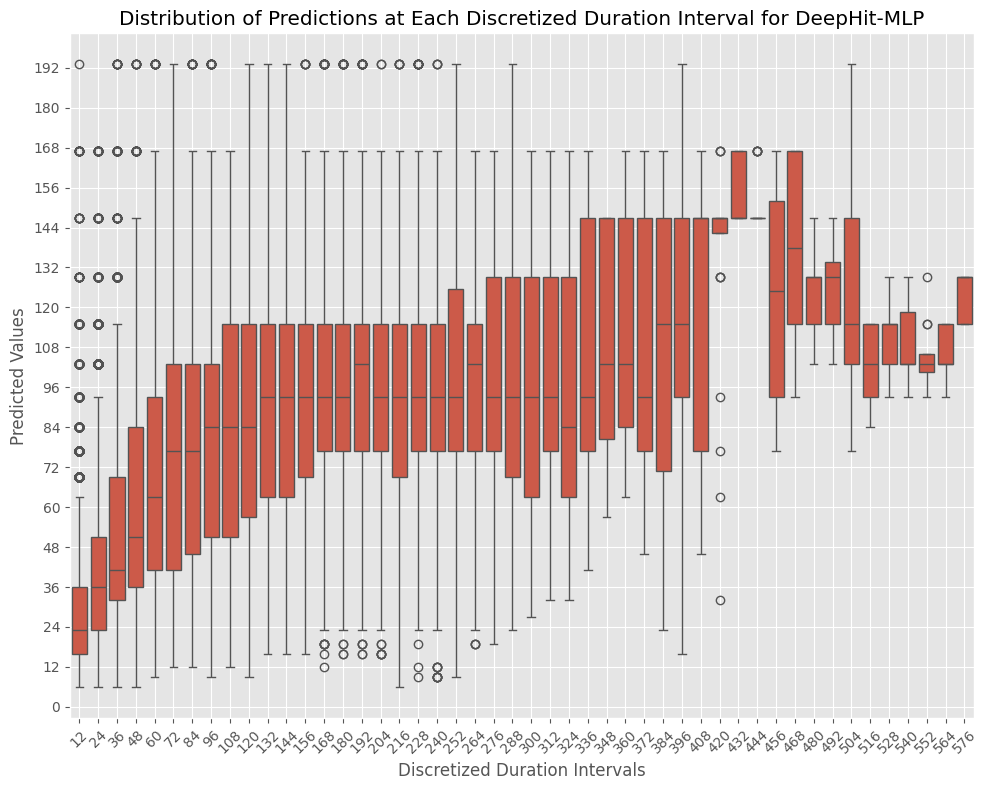

In [370]:
import seaborn as sns

model_column = 'DeepHit-MLP'
tmp_df = y_compare_df[y_compare_df.event == 1][['time_to_event', model_column]]
max_duration = tmp_df['time_to_event'].max()
xticks = np.arange(0, max_duration + 12, 12)  # Adjusting this to every 24 hours as per your recent example
tmp_df['binned_duration'] = pd.cut(tmp_df['time_to_event'], bins=xticks, labels=xticks[1:], right=True)

# Plot setup
plt.figure(figsize=(10, 8))
sns.boxplot(x='binned_duration', y=model_column, data=tmp_df)

# Setting x-ticks
plt.xticks(rotation=45)
# Setting y-ticks
y_max = tmp_df[model_column].max()
plt.yticks(np.arange(0, y_max, 12)) 

plt.title(f'Distribution of Predictions at Each Discretized Duration Interval for {model_column}')
plt.xlabel('Discretized Duration Intervals')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2647944/3604309511.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.loc[:, 'Abs Error'] = np.abs(tmp_df['time_to_event'] - tmp_df[model_column])
/tmp/ipykernel_2647944/3604309511.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['binned_duration'] = pd.cut(tmp_df['time_to_event'], bins=xticks, labels=xticks[1:], right=True)
/tmp/ipykernel_2647944/3604309511.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of 

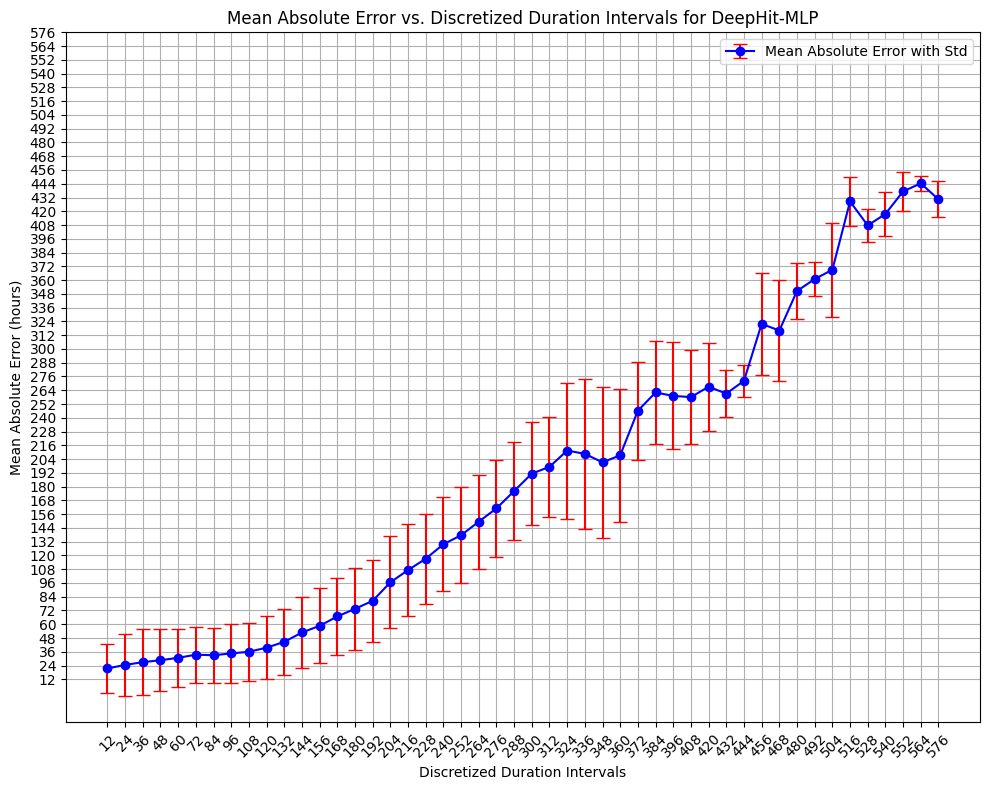

In [170]:
# Choose one model for simplicity, here assuming the first model's name is known as 'Model1'
model_column = 'DeepHit-MLP'

tmp_df = y_compare_df[y_compare_df.event==1]

# Calculate absolute errors
tmp_df.loc[:, 'Abs Error'] = np.abs(tmp_df['time_to_event'] - tmp_df[model_column])

max_duration = tmp_df['time_to_event'].max()
xticks = np.arange(0, max_duration + 12, 12)  
tmp_df['binned_duration'] = pd.cut(tmp_df['time_to_event'], bins=xticks, labels=xticks[1:], right=True)

# Group by durations_test to calculate mean and std of the absolute errors
grouped_data = tmp_df.groupby('binned_duration')['Abs Error'].agg(['mean', 'std'])

# Use the durations_test values directly for x-axis
x_values = grouped_data.index

# Plotting
plt.figure(figsize=(10, 8))
plt.errorbar(x=xticks[1:], y=grouped_data['mean'], yerr=grouped_data['std'], fmt='o-', ecolor='red', capsize=5, color='blue', label='Mean Absolute Error with Std')
plt.xticks(ticks=xticks[1:], labels=[f"{label}" for label in xticks[1:]], rotation=45)
plt.yticks(ticks=xticks[1:], labels=[f"{label}" for label in xticks[1:]])


plt.title(f'Mean Absolute Error vs. Discretized Duration Intervals for {model_column}')
plt.xlabel('Discretized Duration Intervals')
plt.ylabel('Mean Absolute Error (hours)')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

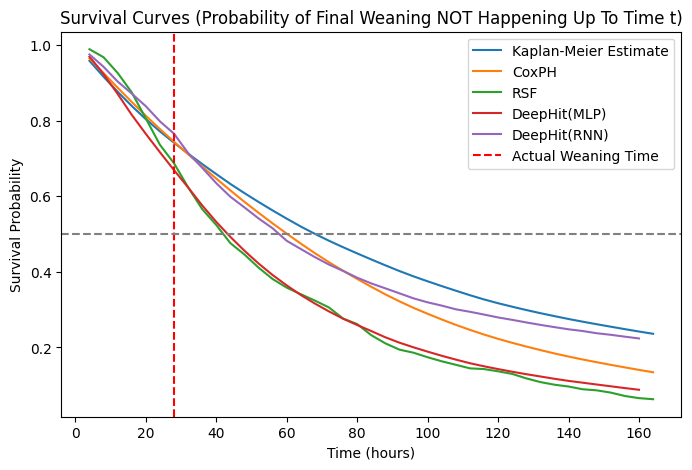

In [308]:
individual_index = 100

# Placeholder for actual weaning time for the patient we want to plot
actual_weaning_time = y_test_surv[[individual_index]]['time']

# Plotting the survival curves for the RSF and CoxPH models
plt.figure(figsize=(8, 5))

# Kaplan-Meier Survival Estimate

plt.plot(time_grid_eval, km_surv.iloc[:, individual_index], label='Kaplan-Meier Estimate')
plt.plot(time_grid_eval, cph_surv.iloc[:, individual_index], label='CoxPH')
plt.plot(time_grid_eval, rsf_surv.iloc[:, individual_index],label='RSF')
# plt.plot(time_grid_eval, deepsurv_mlp_surv.iloc[mask_deepsurv, individual_index], label='DeepSurv(MLP)')
plt.plot(deephit_mlp_surv.iloc[mask_deephit].index, deephit_mlp_surv.iloc[mask_deephit, individual_index], label='DeepHit(MLP)')
plt.plot(deephit_mlp_surv.iloc[mask_deephit].index, deephit_rnn_surv.iloc[mask_deephit, individual_index], label='DeepHit(RNN)')


# Adding a vertical line for the actual weaning time
plt.axvline(x=actual_weaning_time, color='red', linestyle='--', label='Actual Weaning Time')
plt.axhline(y=0.5, color='gray', linestyle='--')

# Adding plot title and labels
plt.title('Survival Curves (Probability of Final Weaning NOT Happening Up To Time t)')
plt.xlabel('Time (hours)')
plt.ylabel('Survival Probability')
plt.legend()

# Show the plot
plt.show()


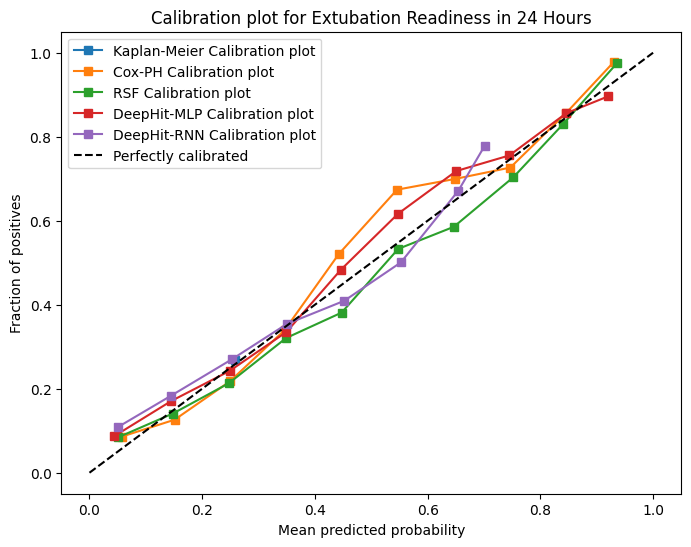

In [358]:
# check the calibration

models_surv = [
    ('Kaplan-Meier', km_surv),
    ('Cox-PH', cph_surv),
    ('RSF', rsf_surv),
    ('DeepHit-MLP', deephit_mlp_surv),
#     ('DeepSurv-MLP', deepsurv_mlp_ev),
    ('DeepHit-RNN', deephit_rnn_surv)
]

time_point = 24
# Assuming 'time_grid' is an array of time points corresponding to your survival data
time_point_index = np.where(time_grid == time_point)[0][0]

# Prepare the actual event data (this remains constant for all models)
event_occurred = y_test_surv['time'] <= time_point

# Start plotting
plt.figure(figsize=(8, 6))
for model_name, surv in models_surv:
    # Calculate predicted probabilities for the model at the specified time point
    predicted_probabilities = 1 - surv.iloc[time_point_index, :]
    
    # Generate calibration data
    fraction_of_positives, mean_predicted_value = calibration_curve(event_occurred, predicted_probabilities, n_bins=10)

    # Plot the calibration curve for the current model
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'{model_name} Calibration plot')

# Add the line for perfect calibration
plt.plot([0, 1], [0, 1], "k--", label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Calibration plot for Extubation Readiness in {time_point} Hours')
plt.legend()
plt.show()

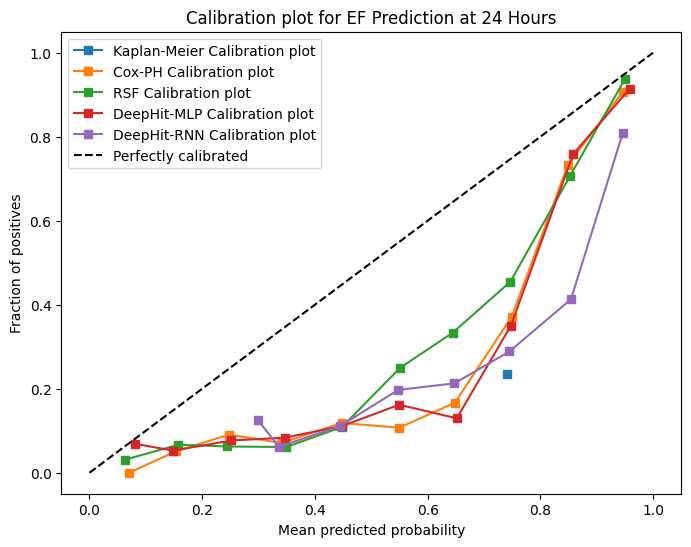

In [352]:

models_surv = [
    ('Kaplan-Meier', km_surv),
    ('Cox-PH', cph_surv),
    ('RSF', rsf_surv),
    ('DeepHit-MLP', deephit_mlp_surv),
#     ('DeepSurv-MLP', deepsurv_mlp_ev),
    ('DeepHit-RNN', deephit_rnn_surv)
]

time_point = 24
time_point_index = np.where(time_grid == time_point)[0][0]
ef_mask = (y_test_surv['time']<=4)
event_occurred = (y_test_surv['event'][ef_mask]==0)

# Start plotting
plt.figure(figsize=(8, 6))
for model_name, surv in models_surv:
    # Calculate predicted probabilities for the model at the specified time point
    predicted_probabilities = surv.iloc[time_point_index, ef_mask] # probability of EF if extubated within 4hrs
    
    # Generate calibration data
    fraction_of_positives, mean_predicted_value = calibration_curve(event_occurred, predicted_probabilities, n_bins=10)

    # Plot the calibration curve for the current model
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'{model_name} Calibration plot')

# Add the line for perfect calibration
plt.plot([0, 1], [0, 1], "k--", label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Calibration plot for EF Prediction at {time_point} Hours')
plt.legend()
plt.show()



## Evaluate on EF cases

In [409]:
best_model = deephit_mlp_model

In [69]:
if 'vent_start_time' not in y_tracker_test.columns:
    y_tracker_test = y_tracker_test.merge(all_df[['encounterId', 'timestamp', 
                                            'vent_start_time']], on=['encounterId', 'timestamp'], how='left')
    
mask_ef = ((~y_tracker_test['event_description'].str.startswith('Not Extubated')) & 
           (y_tracker_test.time_to_event==1) &
          (y_tracker_test['first_extubation_time'] - y_tracker_test['vent_start_time'] > 6))
X_reintub_test_seq = X_test_seq[mask_ef]
y_tracker_reintub_test = y_tracker_test[mask_ef].reset_index(drop=True)
X_reintub_test = X_reintub_test_seq.copy()


In [70]:
y_tracker_reintub_test.event_description.value_counts()

event_description
No 48h Observation - Alive    402
Successful Extubation         298
Extubation Failure             64
Name: count, dtype: int64

In [402]:
def median_survival_times(surv):
    """ Calculate the median survival times from the survival functions. """
    def find_median_time(surv_series):
        below_half = surv_series[surv_series < 0.5]
        return below_half.index[0] if not below_half.empty else surv_series.index[-1]

    return surv.apply(find_median_time, axis=0)

try: 
    net_type = type(best_model.net)
    if net_type is not LSTMEncoder:
        X_reintub_test = X_reintub_test[:, -1]
    best_model_surv = best_model.predict_surv_df(X_reintub_test)
except:
    X_reintub_test = X_reintub_test[:, -1]
    best_model_surv_np = np.row_stack([fn(time_grid) for fn in best_model.predict_survival_function(X_reintub_test)])
    best_model_surv = pd.DataFrame(best_model_surv_np.transpose(), index=time_grid)

y_tracker_reintub_test['estimated_TTE'] = median_survival_times(best_model_surv)

In [403]:
y_tracker_reintub_test.groupby(['num_intub']).estimated_TTE.mean()

num_intub
1    21.947218
2    49.650000
3    52.750000
Name: estimated_TTE, dtype: float64

In [407]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, make_scorer, precision_recall_curve, average_precision_score

threshold_time = 28
time_point_index = np.where(best_model_surv.index == threshold_time)[0][0] 
y_ef_proba = best_model_surv.iloc[time_point_index, :]
y_ef_pred = (y_ef_proba>0.5).astype(int)
y_ef_test = (y_tracker_reintub_test.num_intub>1).astype(int)

accuracy = accuracy_score(y_ef_test, y_ef_pred)
precision_metric = precision_score(y_ef_test, y_ef_pred, zero_division=1)
recall_metric = recall_score(y_ef_test, y_ef_pred, zero_division=1)
f1 = f1_score(y_ef_test, y_ef_pred, zero_division=1)

roc_auc = roc_auc_score(y_ef_test, y_ef_proba)

precision, recall, _ = precision_recall_curve(y_ef_test, y_ef_proba)
auprc = auc(recall, precision)

print("Confusion Matrix:\n", confusion_matrix(y_ef_test, y_ef_pred))

print("Accuracy:", accuracy)
print("Precision:", precision_metric)
print("Recall:", recall_metric)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("AUPRC:", auprc)
print("Classification Report:\n", classification_report(y_ef_test, y_ef_pred))
    


Confusion Matrix:
 [[599 102]
 [ 37  27]]
Accuracy: 0.8183006535947712
Precision: 0.20930232558139536
Recall: 0.421875
F1-score: 0.27979274611398963
ROC-AUC: 0.6939416904422254
AUPRC: 0.260529789406942
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.90       701
           1       0.21      0.42      0.28        64

    accuracy                           0.82       765
   macro avg       0.58      0.64      0.59       765
weighted avg       0.88      0.82      0.84       765



## Visualizations

In [13]:
import joblib
import yaml

In [14]:
id_holder = ["NIC:236574:1823358900", "7612", "NND:1014879:1724847000", "856", "13636", "6362", "NND:195061:1734892380", "16943", "NND:1169483:1891444200", "23337", "12621", "NIC:1107845:1820912100", "NIC:655420:1716997800", "10504", "22762", "NND:244651:1751386080", "12116", "13612", "NIC:209646:1709476200", "NIC:652333:1828381500", "10054", "NIC:1043277:1757815200", "NIC:126973:1706812200", "12931", "NIC:1262485:1959355620", "NIC:1134354:1844179140", "15004", "13724", "NIC:1071028:1796746200", "NIC:1131988:1844529300", "NND:1117901:1828916880", "NIC:1069547:1781556000", "3981", "NIC:1083446:1823270400", "NND:1167767:1876406220", "NND:1082623:1794469800", "NIC:1250599:1949816640", "6065", "NIC:9610:1724953500", "NND:1122945:1833995100", "NIC:1104786:1816477500", "NIC:46713:1971791640", "14259", "NND:1109892:1823967780", "NND:1043097:1855930860", "NND:235314:1704929400", "NIC:1107205:1819049400", "NND:1138385:1847704200", "NIC:1284886:1978112700", "1259", "NIC:1119571:1836334800", "NIC:1015684:1819719000", "8545", "NIC:203536:1675359000", "6349", "NIC:1052081:1803829500", "16884", "NND:1302101:1987370100", "NIC:1202084:1919949060", "29931", "NIC:1079776:1791484500", "NIC:1022857:1742148000", "20857", "NIC:1131776:1849704600", "10998", "NIC:1031797:1746030000", "NND:1185888:1888410600", "NIC:207983:1767708000", "NIC:1027680:1757255400", "NIC:1137656:1860157740", "NIC:1086326:1798431000", "NND:1139321:1867606200", "12101", "32254", "NIC:1068881:1801573800", "NIC:1029144:1761596100", "21530", "NND:1259647:1957087080", "2318", "NIC:218870:1687725000", "NIC:1210163:1920117300", "NIC:1117903:1963601100", "8984", "10015", "NIC:1259324:1958749982", "2035", "4890", "NIC:1158742:1865697840", "NND:1242304:1944851700", "31319", "906", "NND:171458:1676541300", "NND:1053663:1764964800", "27281", "14016", "NIC:1076122:1787629080", "10358", "NND:195396:1721431800", "9921", "998", "NIC:1069927:1897576800", "NND:1062042:1913922000", "13741", "13028", "NIC:1129342:1840720980", "16627", "NIC:1096159:1808151000", "NIC:1165159:1875363300", "17948", "NIC:1165037:1874674500", "31399", "528", "NIC:1114988:1826388600", "6784", "8767", "NIC:1038579:1755968400", "7949", "NIC:1121068:1833547500", "NND:1273724:1968434100", "27857", "5006", "NND:1267514:1962363522", "18316", "640", "NIC:1067601:1786023600", "NIC:17476:1709559300", "NND:1043518:1769086020", "15848", "1217", "18676", "NND:1138687:1848069900", "NIC:221889:1816018320", "NIC:196904:1718113380", "NIC:1133406:1843335420", "NND:1047211:1758498300", "14341", "NIC:238061:1717419600", "NIC:140311:1783014600", "NND:186499:1721243400", "1617", "20822", "NIC:1127460:1850060700", "NIC:224710:1709735100", "16071", "NND:1135454:1845138600", "NND:1118039:1829005020", "2965", "20357", "NIC:1239378:1944927900", "NND:1108176:1819845900", "15883", "2256", "10448", "NIC:1108332:1840809600", "NIC:211951:1726235100", "NIC:230351:1702222200", "NIC:1125093:1851267600", "1245", "31309", "NIC:1181914:1886170860", "NND:1086582:1798690680", "5929", "NIC:1187086:1889310060", "6304", "NIC:1038218:1749758400", "NIC:1107836:1837859400", "NIC:1221581:1954415495", "NIC:1042914:1753821900", "14967", "15356", "5998", "629", "NIC:685962:1758033000", "29568", "NND:1303398:1987644600", "NIC:1058683:1779212700", "19937", "20512", "NIC:1212747:1937059897", "NND:1157282:1864290300", "31885", "368", "NIC:1252735:1970503200", "NIC:224145:1692237600", "NIC:1106517:1833823800", "NIC:1161852:1873384920", "NIC:1078818:1811258400", "NIC:1050263:1761552000", "NIC:1103854:1832600700", "11385", "NIC:1062761:1777308300", "NIC:1171023:1875974700", "NIC:225965:1694710200", "NIC:1014049:1733679000", "NND:1102913:1814695200", "NIC:1277098:1980426960", "NND:1172024:1876350660", "NIC:161426:1759086000", "NIC:1016164:1747772100", "NIC:1137774:1862245800", "NIC:1016364:1742228280", "NIC:1144455:1853159940", "30275", "31130", "NIC:1098831:1820937000", "617", "8095", "3976", "7928", "11193", "9170", "5234", "12556", "1979", "NIC:208735:1712064000", "NIC:176485:1728580500", "27441", "NIC:1090691:1819643340", "7450", "7574", "NIC:1228100:1949245200", "NIC:214376:1704056400", "NIC:1104436:1820847600", "19777", "15902", "1489", "NND:1182471:1885633920", "NIC:187663:1716318900", "NND:1226183:1965064200", "NIC:1069026:1786019100", "NIC:1278465:1970427600", "28398", "14370", "NIC:224785:1693504200", "NIC:1080954:1796920500", "5322", "7186", "NIC:219876:1849371300", "NIC:1013548:1745161200", "16814", "14011", "NND:1043731:1754714700", "NIC:118596:1715088600", "NND:1046249:1762791000", "28152", "NND:1120978:1842719400", "29921", "NND:215555:1687366980", "NIC:1047246:1759339800", "3154", "15141", "5632", "NIC:1127518:1856718000", "NND:1199646:1899572400", "4910", "NND:1190832:1892397420", "NND:1269966:1972042200", "17844", "NIC:1145987:1854399600", "NIC:203014:1693245600", "9550", "20915", "NND:1245388:1945703400", "NIC:1069927:1793733300", "NIC:246593:1749571200", "31862", "NND:1129175:1839689640", "29830", "17191", "NIC:1273590:1976066100", "26657", "4259", "NIC:183000:1681252200", "NND:1263286:1959539400", "10657", "2364", "NND:186499:1675009800", "NND:1078818:1826888700", "NND:1015207:1725543000", "NND:233125:1705172400", "8850", "9567", "13231", "NIC:1066528:1804515000", "NIC:1070576:1793628600", "NIC:214404:1931786927", "NIC:690309:1700756400", "NIC:1090451:1802721600", "1737", "NIC:1160873:1899565320", "9137", "27331", "NIC:1290336:1979168400", "8574", "10392", "NIC:1040821:1839760500", "30621", "24983", "NND:1284886:1974506400", "NND:1113759:1825212600", "18278", "31239", "NIC:1140315:1860180900", "30254", "9944", "17792", "NIC:1153363:1874775360", "NIC:199252:1676901300", "NIC:1074476:1785936600", "2317", "8514", "NIC:1042975:1769358600", "NND:1087242:1799614260", "NIC:1247896:1953051600", "82", "NIC:1141665:1864657800", "NIC:1197193:1915213200", "263", "6528", "NND:1156015:1870019820", "NND:1190560:1892219760", "17853", "131", "NIC:221970:1815424200", "9006", "32414", "NIC:1062103:1775585400", "11973", "NND:1020643:1730958300", "NIC:1108575:1820307600", "32212", "9285", "17441", "15589", "9807", "NIC:1096229:1809974700", "NIC:223022:1719853200", "NIC:243617:1719297000", "NIC:1228648:1932247800", "4915", "NND:215087:1681546200", "NIC:1081784:1818507900", "NIC:1290466:1986646556", "NIC:136148:1715267580", "17820", "789", "30124", "NIC:187788:1739466600", "14893", "NND:1117369:1828614180", "NIC:1012967:1744223400", "9518", "NIC:1064317:1786296600", "NND:1088095:1800354720", "NND:1129934:1840460100", "8939", "28693", "16615", "NIC:224107:1708350000", "NIC:1021624:1747691100", "5180", "7689", "7134", "14395", "11586", "4568", "NIC:1234185:1940852483", "26808", 
             "NND:1083965:1795892400", "17381", "NIC:1136359:1856525100", "4777", "32178", "1733", "NIC:217300:1692197400", "16049", "10147", "17908", "NIC:1056522:1786458600", "NIC:1097814:1813767840", "NIC:689547:1793808000", "NIC:238572:1721573700", "NIC:211994:1693416600", "NIC:178611:1753291800", "NIC:1162686:1885559160", "NND:1142693:1853946900", "NIC:1039891:1750934100", "10655", "NIC:242906:1713396600", "10125", "5848", "NIC:3916:1754404680", "NND:1301548:1986213600", "1592", "25058", "17917", "NIC:1170419:1874887200", "9564", "NIC:225811:1694547000", "8130", "NIC:1296761:1982626800", "NIC:219432:1687851900", "28474", "15978", "17909", "NND:1083368:1795280400", "15152", "NND:1026074:1737113400", "16220", "NIC:1055182:1793634300", "825", "NIC:248416:1727012100", "NIC:1230408:1934301600", "NND:1191345:1895007900", "NIC:202255:1692039900", "NIC:1147841:1857314100", "NIC:246867:1769455200", "NIC:1064430:1776030300", "12404", "NIC:209048:1674468000", "NIC:1100709:1911999000", "NIC:186980:1693324500", "NIC:108819:1685457900", "NND:1022899:1733308200", "NIC:1045985:1786376520", "17819", "NIC:162329:1685634000", "NIC:1241573:1948892231", "NND:1101897:1843248600", "NND:1023631:1734634800", "7737", "16559", "NIC:214925:1683905100", "NIC:196576:1696960800", "NND:1097842:1809829200", "6777", "1009", "NIC:1108673:1827602760", "NIC:1051847:1764792900", "12872", "NIC:232207:1701921000", "NIC:1071621:1819822500", "NIC:217317:1711482000", "12738", "196", "29611", "NIC:194606:1672770600", "NIC:636054:1814455800", "NND:1104505:1816178400", "NIC:203050:1715115600", "NIC:1076112:1794751500", "NIC:1024604:1735324200", "NIC:1067907:1821717300", "12822", "15923", "9028", "NND:1135347:1846103760", "NIC:1132979:1871652960", "NIC:1056207:1801058400", "NND:1139371:1848680100", "NIC:208990:1710511200", "13732", "NIC:1202159:1923682500", "12468", "18018", "NIC:1109670:1839599400", "11492", "8167", "16727", "7379", "17725", "13127", "NIC:219869:1698155160", "NIC:131596:1684872300", "19688", "16883", "16663", "10676", "NIC:1012570:1729878000", "NIC:246478:1726586700", "NND:1018651:1728930000", "12112", "953", "NIC:1226332:1943712000", "6811", "26555", "25638", "NIC:220392:1699011180", "NND:1172739:1876881480", "11313", "8277", "NND:1250399:1950508206", "NIC:1058914:1776189600", "8521", "25090", "NIC:52787:1769373600", "NIC:1036645:1747692900", "16368", "8860", "NIC:221748:1691092800", "NIC:1065028:1802015100", "NIC:1113098:1836495900", "NIC:1151072:1864565400", "NIC:1261584:1971964353", "25564", "NIC:129955:1709565300", "398", "3326", "4258", "29390", "NND:1144849:1859043000", "3058", "8547", "23274", "17384", "13654", "27567", "6629", "9856", "NND:249550:1774965300", "22004", "NIC:219432:1720206000", "NIC:220062:1688665500", "4169", "NND:1066728:1778259600", "28564", "NND:1090920:1815502500", "NIC:1103103:1827514680", "14064", "NIC:93788:1694520300", "24033", "16526", "NND:142662:1731265200", "NIC:1131178:1857823980", "NIC:1124936:1839174600", "NIC:1143086:1852644840", "NIC:1061824:1773402900", "NIC:246311:1746981900", "3265", "32148", "NIC:1125643:1836350880", "18330", "NIC:1060801:1772563500", "NND:1043097:1772565900", "NND:1283230:1973416680", "NND:1187663:1889799420", "NND:1034674:1745555400", "13994", "10167", "8373", "NIC:175703:1756836000", "NND:1113827:1832263800", "NIC:241129:1730986260", "NIC:1084057:1796066700", "13094", "18225", "NIC:181361:1683567300", "10693", "NIC:1032074:1763055900", "NIC:1097678:1825684200", "NND:1108676:1820379900", "NIC:1029694:1762897500", "NIC:1112088:1823713200", "NND:1263804:1960421400", "NIC:1129990:1846244700", "NIC:1021197:1738673400", "NIC:1252735:1951535700", "8952", "NIC:248754:1719959400", "2542", "NIC:1127571:1840196700", "NIC:1148406:1865693220", "NND:212137:1809221520", "32420", "22810", "NND:1178618:1890685800", "NIC:1033012:1743777000", "NND:1064160:1775680200", "6069", "31810", "NIC:1075577:1800800100", "27968", "NIC:220273:1791204300", "1520", "NIC:1132506:1842589800", "4820", "NND:1054981:1932746064", "NND:1183132:1886183100", "1019", "10396", "27123", "NND:1106619:1818295200", "NIC:33749:1890416400", "20204", "NIC:1021240:1731535200", "NIC:1089171:1802041260", "NIC:1083643:1821634200", "3351", "12683", "10995", "23785", "1745", "NIC:12376:1710792000", "NND:1094440:1806379680", "NND:1289646:1978578000", "NIC:1172390:1885221000", "2889", "28744", "NIC:1100726:1836592800", "NIC:1054115:1787925300", "14106", "8633", "NIC:1070979:1783962000", "2438", "NIC:1072575:1819715400", "11251", "7477", "NIC:1070214:1853428500", "600", "NIC:1160454:1866480180", "NIC:1261584:1961175600", "NIC:178156:1684692000", "NIC:1121721:1835436300", "NIC:1042083:1753623000", "NIC:1044855:1761832800", "NND:226660:1703686500", "NIC:1193334:1937495367", "NIC:248846:1720017000", "NIC:1211600:1949760585", "NIC:1190720:1892328300", "930", "19193", "8589", "NIC:1015684:1733845860", "15192", "NND:236982:1706907600", "NIC:1043999:1755012900", "15336", "9713", "8350", "10996", "NIC:1225118:1933594353", "NND:1086744:1799109840", "NIC:1144109:1869930600", "3264", "NIC:1068085:1781531100", "1366", "NIC:1040653:1768487400", "12149", "NIC:1035445:1753034400", "1575", "NIC:1089521:1829402100", "NIC:1018257:1923153966", "8345", "NIC:250011:1745946000", "NIC:237742:1711460700", "25764", "1110", "NIC:1018216:1739814300", "NND:1079460:1811617200", "NIC:1168878:1873569600", "NIC:225154:1709841600", "NND:222831:1691499600", "NIC:1061744:1773104400", "376", "NIC:222492:1695141900", "NIC:1228260:1936624500", "NIC:1018767:1729857900", "NIC:248754:1791747900", "NIC:19874:1730732400", "13259", "NIC:35777:1691514000", "29578", "20062", "28533", "449", "NIC:1168703:1939561500", "19530", "NND:1213441:1923743160", "12042", "NIC:1147036:1855349700", "NND:1260091:1957444500", "11359", "5657", "NIC:1046162:1759971600", "29696", "NIC:214149:1702041600", "19070", "26129", "NIC:1041845:1762784100", "15604", "NIC:248846:1739371800", "NIC:230488:1704369900", "NIC:1129861:1840240200", "NND:1102338:1815651660", "NND:1031955:1742776200", "4906", "3693", "NIC:189128:1786893420", "14334", "22861", "12782", "NIC:1134933:1844883000", "NIC:1065418:1799769600", "NIC:231860:1703249400", "31815", "1250", "NIC:1242810:1952104500", "NND:1115530:1826839500", "NND:1054522:1786548660", "NIC:1160577:1880632200", "NND:1091627:1806332100", "NIC:1251944:1951171260", "NIC:645418:1716307500", "24090", "NND:1190243:1892032920", "NIC:231879:1724246100", "NND:1098545:1810472100", "NIC:1163250:1868758200", "NIC:119907:1781014500", "27082", "31339", "NIC:1012967:1725699600", "NIC:176642:1678214400", "7850", "15360", "31347", "NIC:242266:1738184400", "27915", "7823", "9799", "NND:1124577:1835393400", 
             "NND:165681:1685763900", "NIC:249529:1720905000", "16733", "3894", "12485", "NIC:1116300:1910955000", "NND:248658:1719897300", "31670", "NIC:1048504:1791913500", "NND:1297879:1984075200", "NND:1091628:1803740940", "NIC:1015023:1722096600", "NIC:199568:1696463100", "10193", "NIC:1223807:1947946208", "NIC:1091465:1806244320", "NIC:1083121:1794957720", "NIC:1025847:1738930500", "15886", "11088", "1391", "NIC:205519:1679513700", "16925", "19393", "NIC:1052344:1799082000", "10053", "NIC:249529:1801771200", "12897", "NND:1060929:1780352400", "30620", "8335", "NIC:205267:1746718200", "NIC:1189500:1891270620", "NIC:1195463:1896466500", "7274", "8704", "NIC:656031:1684439100", "NIC:211146:1678375860", "NIC:1077988:1831923300", "NIC:1085508:1810566300", "NIC:1067110:1792070400", "NIC:1127387:1837878000", "4388", "4914", "6259", "6228", "NIC:1083013:1819979280", "30864", "NIC:192178:1698169200", "NIC:1058245:1777983000", "NIC:221534:1689184800", "NIC:224157:1755529020", "NIC:1064915:1776537000", "21898", "21126", "NND:1227772:1932165000", "7861", "NIC:205371:1673536800", "NND:1252791:1962877707", "NIC:1036407:1752498000", "NND:235315:1857754800", "NND:1084941:1796828700", "15966", "NND:1154666:1862103600", "NIC:211449:1698063600", "NIC:1069162:1780617600", "NND:1294482:1985340354", "6884", "13007", "NIC:248754:1736114400", "NND:1197577:1898030820", "NIC:1205806:1915277580", "NIC:249686:1721100600", "31736", "1402", "NND:1190998:1892647800", "NIC:1231676:1953383840", "NIC:161973:1695315300", "3572", "27080", "30467", "NIC:1165771:1871059500", "10921", "NIC:1257090:1970923010", "15009", "NIC:1141401:1859661000", "NIC:1052027:1767898500", "17440", "NIC:248754:1736627400", "NIC:16678:1684342020", "NND:225947:1694688900", "NND:1023381:1733789700", "12253", "5085", "29289", "NIC:1085340:1854972000", "NIC:1079256:1794240900", "NIC:1290329:1980408056", "NND:1085952:1797866700", "3665", "14560", "NIC:1071621:1879004400", "10968", "NIC:1056675:1768433400", "12812", "NIC:1053592:1770743100", "5055", "NIC:1220935:1923962400", "23677", "NIC:1118366:1846940880", "NND:1114273:1826850300", "NIC:213897:1682614800", "15077", "NIC:243617:1793022000", "7095", "NND:1263081:1968249900", "NIC:174667:1807630200", "29829", "NIC:215084:1684548000", "NND:1247984:1948044600", "NIC:1014710:1727708940", "NIC:1154352:1861581300", "NND:1257654:1954994400", "NIC:1066697:1778690100", "NIC:248565:1742739600", "10946", "NIC:1230523:1944845700", "15614", "NIC:1096297:1812379800", "NIC:1017749:1727999400", "30167", "18583", "23590", "NND:230705:1700239500", "7321", "NIC:215163:1748527200", "14647", "NIC:1242530:1955730840", "28025", "3783", "NIC:1143280:1863374400", "NIC:1075912:1787446920", "7721", "NIC:190971:1683221400", "22999", "NIC:1095313:1807107600", "NIC:1047027:1758214800", "29245", "822", "13009", "NND:186499:1866721800", "9395", "6016", "10298", "6873", "NIC:1169682:1874241000", "NIC:1046249:1799249100", "NIC:1156857:1870439700", "NIC:1051305:1769521500", "3135", "31850", "NIC:91754:1826827200", "12344", "NND:1233786:1942942507", "4738", "NIC:1169679:1890057780", "NND:1206910:1909791900", "NND:174898:1835739900", "NND:249817:1721215800", "10062", "NIC:130327:1672777200", "15678", "NIC:1025262:1738933200", "31950", "NIC:112259:1684081500", "NIC:1077426:1788985200", "NND:218210:1688907900", "31544", "896", "8572", "NIC:1056433:1796575500", "NIC:217317:1804170000", "16349"]


In [15]:
with open('/home/el2522/Documents/DS217/users/el2522/TrajectoryAnalysis/results/ef_prediction_window_1_12/checkpoints/Random Forest_best_model.joblib', 'rb') as f:
    ef_model = joblib.load(f)
    

In [16]:
import json
from pathlib import Path

# Get the current file's directory
current_dir = Path('/home/el2522/Documents/DS217/users/el2522/TTEAnalysis')

# Find the common parent directory
common_parent = current_dir.parent

# Add the TrajectoryAnalysis directory to the Python path
traj_analysis_dir = common_parent / "TrajectoryAnalysis"
sys.path.append(str(traj_analysis_dir))

# Now you can import from the TrajectoryAnalysis project
from src.trainers.base_trainer import BaseTrainer

# Define paths
base_path = Path('/home/el2522/Documents/DS217/users/el2522/TrajectoryAnalysis/results/dynamic_prediction_window_1_12')
config_path = os.path.join(base_path, 'config.yaml')
model_path = os.path.join(base_path, 'checkpoints/model-epoch=52-val_loss=0.45.ckpt')

# Load the config
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

dynamic_model = BaseTrainer.load_from_checkpoint(model_path, config=config).to('cpu').model
dynamic_model.eval()

print("Model loaded successfully and set to evaluation mode.")



Model loaded successfully and set to evaluation mode.


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style for a more modern look
plt.style.use('ggplot')
# Use a color-blind friendly palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_extubation_analysis(y_tracker_reintub_tmp, right_side_column='TTE_pred', right_side_label='Predicted Time to Event (hours)'):
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Plot probabilities on the left y-axis
#     prob_columns = ['TTE_proba', 'EF_proba', 'Dynamic_proba']
#     labels = ['TTE Analysis', 'Failure Pred', 'Readiness Pred']
    
    prob_columns = ['EF_proba', 'Dynamic_proba']
    labels = ['Failure Pred', 'Readiness Pred']
    
    for i, (col, label) in enumerate(zip(prob_columns, labels)):
        ax1.plot(y_tracker_reintub_tmp['timestamp'], y_tracker_reintub_tmp[col], 
                 label=label, color=colors[i], linewidth=2, alpha=0.8)

    # Add horizontal line at probability 0.5
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Probability Threshold')
        
    ax1.set_xlabel('Time (hours)', fontsize=12)
    ax1.set_ylabel('Probability of Fail Extubation', fontsize=12, color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    ax1.set_ylim(0, 1)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create a second y-axis for the specified column
    ax2 = ax1.twinx()
    ax2.plot(y_tracker_reintub_tmp['timestamp'], y_tracker_reintub_tmp[right_side_column], 
             color=colors[3], linewidth=2, label=right_side_label)
    ax2.set_ylabel(right_side_label, fontsize=12, color=colors[3])
    ax2.tick_params(axis='y', labelcolor=colors[3])
    
    # Mark intubation and extubation times
    events = {'Intubation': ('airwayStatus_Intubated', colors[4], '^'), 
              'Extubation': ('airwayStatus_Extubated', colors[5], 'v')}
    
    for event, (column, color, marker) in events.items():
        event_times = y_tracker_reintub_tmp.loc[y_tracker_reintub_tmp[column] == 1, 'timestamp']
        ax2.scatter(event_times, [ax2.get_ylim()[1]]*len(event_times), 
                    color=color, marker=marker, s=100, label=f'{event} Time', zorder=5)
        for time in event_times:
            ax2.axvline(x=time, color=color, linestyle='--', alpha=0.5)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', 
               bbox_to_anchor=(1.05, 0.5), fontsize=10, frameon=True, framealpha=0.9)
    
    plt.title('Ventilation Trajectory Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Add timestamp information
    age = y_tracker_reintub_tmp['age'].iloc[0]
#     diagnosis = y_tracker_reintub_tmp['first_extubation_time'].max()
    num_intub = y_tracker_reintub_tmp['num_intub_x'].iloc[0]
    event = y_tracker_reintub_tmp['event_description_x'].iloc[0]
    plt.text(0.01, 0.01, f"Age: {int(age)} month\nNum_intub: {num_intub}\nEvent: {event}", 
             transform=ax1.transAxes, fontsize=9, verticalalignment='bottom', 
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    return fig, ax1, ax2


# Prepare data for all models
id_tmp = y_tracker_test[(y_tracker_test.num_intub==1)&
                        (y_tracker_test.first_extubation_time<=100)&
                       (y_tracker_test.encounterId.isin(id_holder))].encounterId.unique()[30]
mask_tmp = y_tracker_test.encounterId == id_tmp
X_reintub_tmp = X_test_seq[mask_tmp] if type(best_model.net) is LSTM else X_test_tab[mask_tmp]
X_reintub_tmp_seq = X_test_seq[mask_tmp]
y_tracker_reintub_tmp = y_tracker_test[mask_tmp].merge(all_df, on=['encounterId', 'timestamp'], how='left')

# TTE model predictions
# best_model_surv_tmp = best_model.predict_surv_df(X_reintub_tmp)
# y_tracker_reintub_tmp["TTE_proba"] = best_model_surv_tmp.iloc[time_point_index, :].values
# y_tracker_reintub_tmp["TTE_pred"] = median_survival_times(best_model_surv_tmp).values

# Extubation failure model predictions
ef_proba = ef_model.predict_proba(X_reintub_tmp)[:, 1]  # Assuming second column is probability of failure
y_tracker_reintub_tmp["EF_proba"] = ef_proba

# Dynamic model predictions
if model_config['type'] == 'lstm':
    dynamic_proba = 1 - torch.sigmoid(dynamic_model(torch.tensor(X_reintub_tmp_seq[:, -8:], dtype=torch.float32))).detach().numpy().flatten()
else:
    dynamic_proba = 1 - torch.sigmoid(dynamic_model(torch.tensor(X_reintub_tmp, dtype=torch.float32))).detach().numpy().flatten()
y_tracker_reintub_tmp["Dynamic_proba"] = dynamic_proba

# Create the plot with flexibility for the right-hand side column
fig, ax1, ax2 = plot_extubation_analysis(y_tracker_reintub_tmp, right_side_column='mPower', 
                                         right_side_label='Mechanical Power')

plt.show()

# Display patient information
y_tracker_test.loc[y_tracker_test.encounterId==id_tmp, 
        ['encounterId', 'vent_start_time', 'first_extubation_time', 'num_intub', 'event_description']].iloc[0:1]

ValueError: X has 43 features, but RandomForestClassifier is expecting 35 features as input.

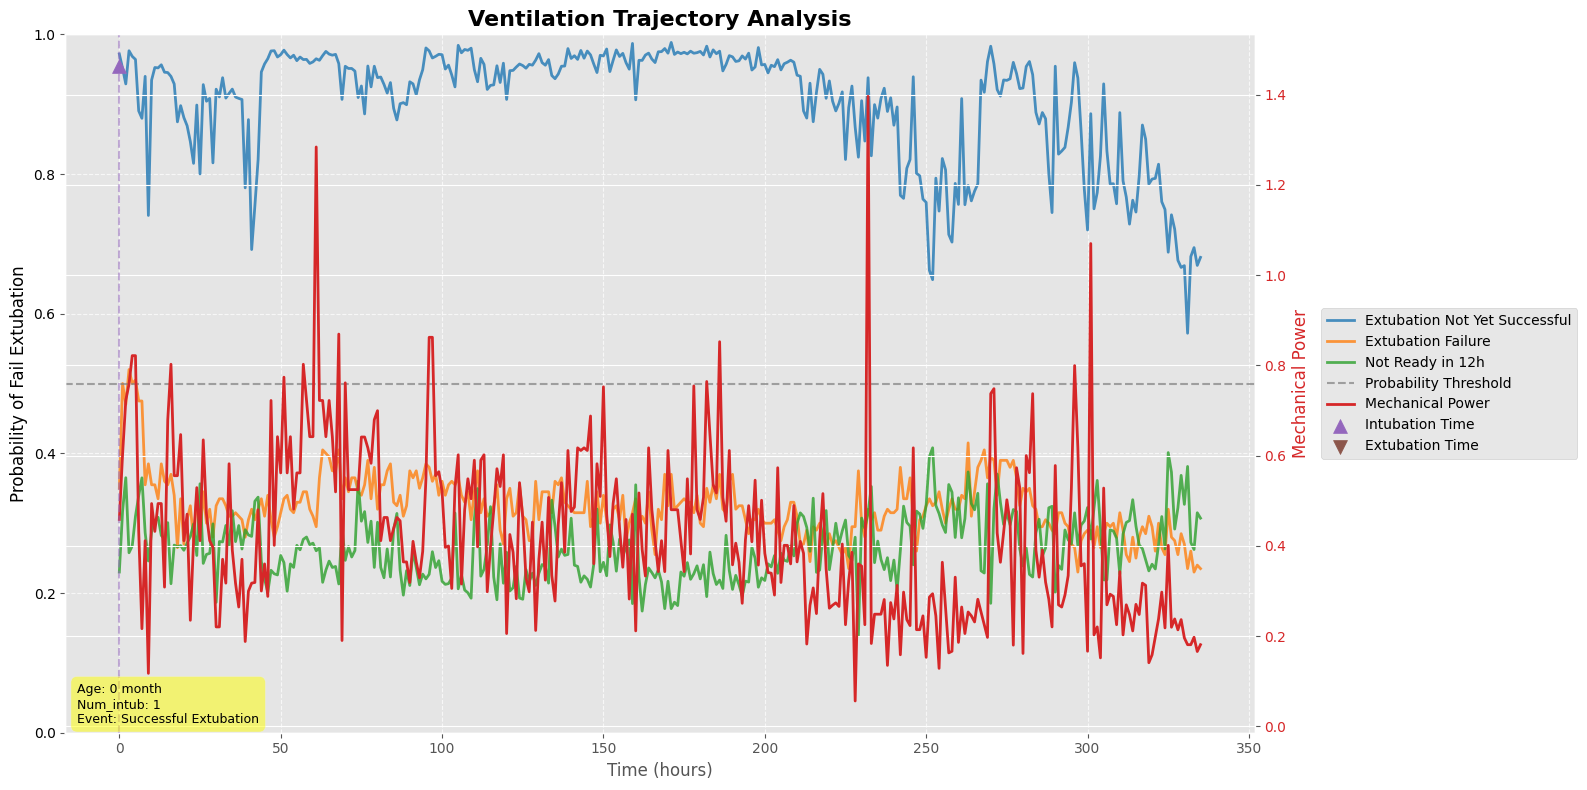

,encounterId,vent_start_time,first_extubation_time,num_intub,event_description
36995,NIC:205371:1673536800,0,336.0,1,Successful Extubation


In [312]:

# Prepare data for all models
id_tmp = y_tracker_test[(y_tracker_test.num_intub==1)&
                        (y_tracker_test.first_extubation_time>300)&
                       (y_tracker_test.encounterId.isin(id_holder))].encounterId.unique()[1]
mask_tmp = y_tracker_test.encounterId == id_tmp
X_reintub_tmp = X_test_seq[mask_tmp] if type(best_model.net) is LSTM else X_test_tab[mask_tmp]
X_reintub_tmp_seq = X_test_seq[mask_tmp]
y_tracker_reintub_tmp = y_tracker_test[mask_tmp].merge(all_df, on=['encounterId', 'timestamp'], how='left')

# TTE model predictions
best_model_surv_tmp = best_model.predict_surv_df(X_reintub_tmp)
y_tracker_reintub_tmp["TTE_proba"] = best_model_surv_tmp.iloc[time_point_index, :].values
y_tracker_reintub_tmp["TTE_pred"] = median_survival_times(best_model_surv_tmp).values

# Extubation failure model predictions
ef_proba = ef_model.predict_proba(X_reintub_tmp)[:, 1]  # Assuming second column is probability of failure
y_tracker_reintub_tmp["EF_proba"] = ef_proba

# Dynamic model predictions
if model_config['type'] == 'lstm':
    dynamic_proba = 1 - torch.sigmoid(dynamic_model(torch.tensor(X_reintub_tmp_seq[:, -8:], dtype=torch.float32))).detach().numpy().flatten()
else:
    dynamic_proba = 1 - torch.sigmoid(dynamic_model(torch.tensor(X_reintub_tmp, dtype=torch.float32))).detach().numpy().flatten()
y_tracker_reintub_tmp["Dynamic_proba"] = dynamic_proba

# Create the plot with flexibility for the right-hand side column
fig, ax1, ax2 = plot_extubation_analysis(y_tracker_reintub_tmp, right_side_column='mPower', 
                                         right_side_label='Mechanical Power')

plt.show()

# Display patient information
y_tracker_test.loc[y_tracker_test.encounterId==id_tmp, 
        ['encounterId', 'vent_start_time', 'first_extubation_time', 'num_intub', 'event_description']].iloc[0:1]


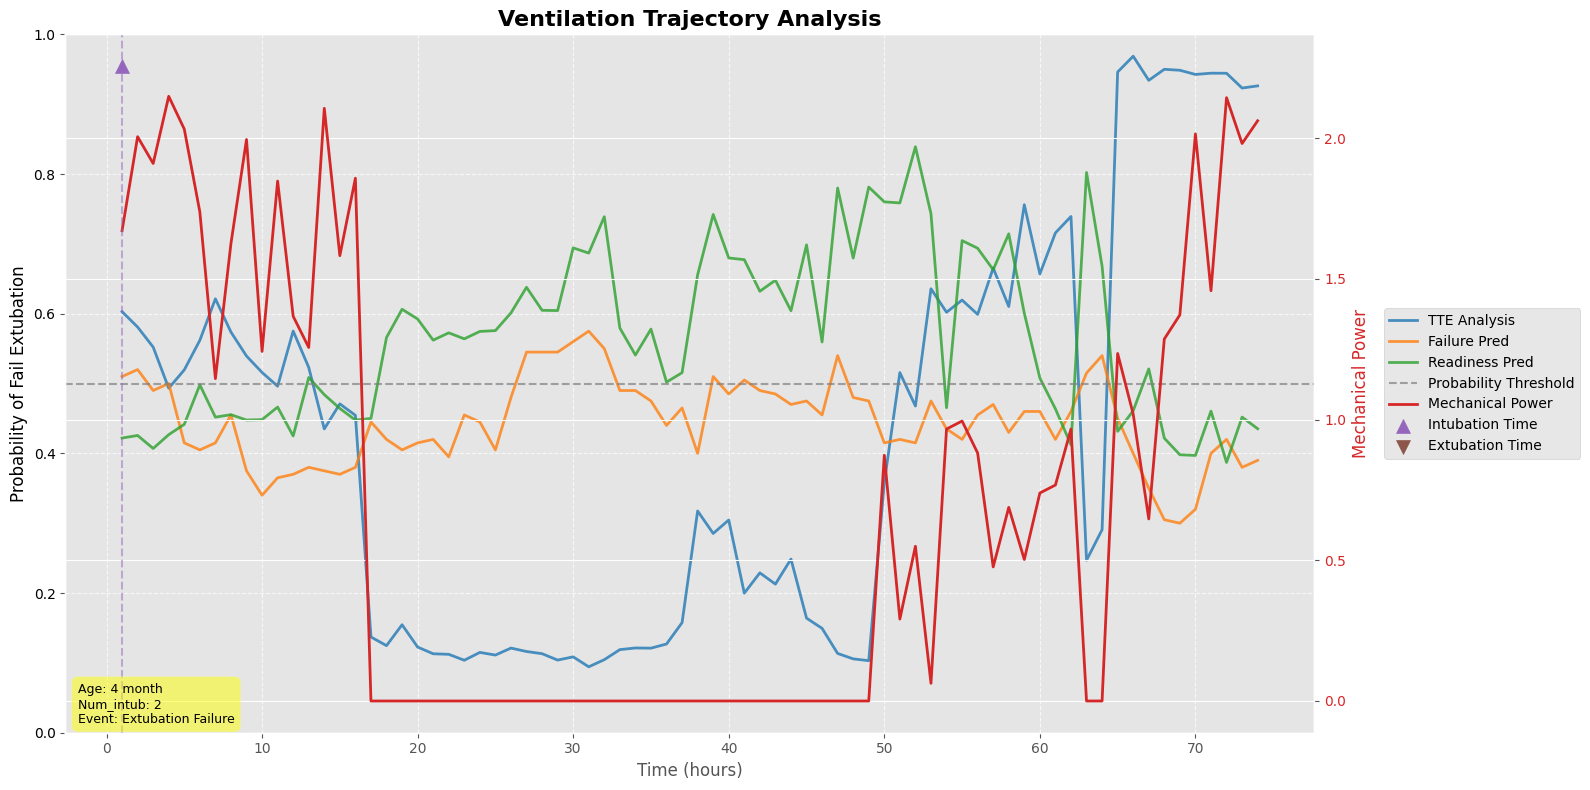

,encounterId,vent_start_time,first_extubation_time,num_intub,event_description
41911,NIC:1015764:1729169700,1,75.0,2,Extubation Failure


In [411]:

# Prepare data for all models
id_tmp = y_tracker_test[(y_tracker_test.num_intub>1)&
                       (y_tracker_test.encounterId.isin(id_holder))].encounterId.unique()[8]
mask_tmp = y_tracker_test.encounterId == id_tmp
X_reintub_tmp = X_test_seq[mask_tmp] if type(best_model.net) is LSTM else X_test_tab[mask_tmp]
X_reintub_tmp_seq = X_test_seq[mask_tmp]
y_tracker_reintub_tmp = y_tracker_test[mask_tmp].merge(all_df, on=['encounterId', 'timestamp'], how='left')

# TTE model predictions
best_model_surv_tmp = best_model.predict_surv_df(X_reintub_tmp)
y_tracker_reintub_tmp["TTE_proba"] = best_model_surv_tmp.iloc[time_point_index, :].values
y_tracker_reintub_tmp["TTE_pred"] = median_survival_times(best_model_surv_tmp).values

# Extubation failure model predictions
ef_proba = ef_model.predict_proba(X_reintub_tmp)[:, 1]  # Assuming second column is probability of failure
y_tracker_reintub_tmp["EF_proba"] = ef_proba

# Dynamic model predictions
if model_config['type'] == 'lstm':
    dynamic_proba = 1 - torch.sigmoid(dynamic_model(torch.tensor(X_reintub_tmp_seq[:, -8:], dtype=torch.float32))).detach().numpy().flatten()
else:
    dynamic_proba = 1 - torch.sigmoid(dynamic_model(torch.tensor(X_reintub_tmp, dtype=torch.float32))).detach().numpy().flatten()
y_tracker_reintub_tmp["Dynamic_proba"] = dynamic_proba

# Create the plot with flexibility for the right-hand side column
fig, ax1, ax2 = plot_extubation_analysis(y_tracker_reintub_tmp, right_side_column='mPower', 
                                         right_side_label='Mechanical Power')

plt.show()

# Display patient information
y_tracker_test.loc[y_tracker_test.encounterId==id_tmp, 
        ['encounterId', 'vent_start_time', 'first_extubation_time', 'num_intub', 'event_description']].iloc[0:1]
